# Prédiction de la direction des prix sur les marchés financiers


## 1. Introduction et présentation du problème



### 1.1 Contexte et enjeux

Dans le cadre de ce challenge (issu du Collège de France ou du Lab Banque de France), nous disposons de données de marché avec pour objectif de prédire la direction du prix (baisse, stable, hausse) en fin de journée, à partir des rendements du matin.

Ce marché américain étant particulièrement liquide, l'enjeu est de pouvoir estimer la tendance entre 14h et 16h pour prendre des décisions d'investissement ou d'arbitrage.



### 1.2 Description des données

- **Index des données**
  - Chaque ligne représente un jour donné et une action donnée (identifiants : `day` et `equity`).
  - Les colonnes `r0` à `r52` correspondent aux rendements (en points de base) toutes les 5 minutes entre 9h30 et 14h.

- **Variables explicatives**
  - Les 53 rendements (`r0, r1, …, r52`), éventuellement d'autres features dérivées.

- **Variable cible**
  - `reod` {-1, 0, 1} indiquant la tendance de l'actif entre 14h et 16h (baisse, stable ou hausse).



### 1.3 Problématique et défis

Notre mission est de prédire la classe de rendement (`reod`) en fin de journée, à partir des données matinales. Les défis principaux sont :

- La **taille importante** du dataset (plusieurs centaines de milliers de lignes).
- La **présence de valeurs manquantes** (`NaN`).
- L'**absence de jours/actions communs** entre le jeu d'entraînement et le jeu de test, ce qui complique l'utilisation directe de `equity` ou `day` en tant que features.
- Le **risque de surcoût mémoire** et de temps de calcul avec certains modèles comme les Random Forest.



## 2. Exploration des données (EDA)


### 2.1 Aperçu des données et analyse des valeurs manquantes

Nous commençons par explorer les données d'entraînement pour comprendre leur structure et la distribution des valeurs manquantes.


### Importation des librairies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import datetime

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Configuration de l'affichage
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)
plt.rcParams['figure.figsize'] = (12, 8)

### Importation des données

In [2]:

# Importation des données d'entraînement
X = pd.read_csv('input_training.csv')
X.sort_values(by="ID",inplace=True)
y = pd.read_csv('output/output_training_gmEd6Zt.csv')

# Importation des données de test
data_test = pd.read_csv('input_test.csv')
data_test.sort_values(by="ID",inplace=True)
y_test = pd.read_csv("output/output_test_random.csv")

# Fusion des données et labels
X_train = pd.merge(X, y, on="ID").copy()
data_test.sort_values(by="ID", inplace=True)
X_test = pd.merge(data_test, y_test, on="ID").copy()

# Aperçu des données
print("\n--- Aperçu des données d'entraînement ---")
print(f"Nombre de lignes train: {X_train.shape[0]}, Nombre de colonnes: {X_train.shape[1]}")
print(f"Nombre de lignes test: {X_test.shape[0]}, Nombre de colonnes: {X_test.shape[1]}")
print("\nPremières lignes:")
display(X_train.head())


--- Aperçu des données d'entraînement ---
Nombre de lignes train: 843299, Nombre de colonnes: 57
Nombre de lignes test: 885799, Nombre de colonnes: 57

Premières lignes:


ID  day  equity      r0      r1     r2     r3     r4     r5     r6  ...  \
0   0  249    1488    0.00     NaN    NaN    NaN   0.00    NaN    NaN  ...   
1   1  272     107   -9.76    0.00 -12.21  46.44  34.08   0.00  41.24  ...   
2   2  323    1063   49.85    0.00   0.00 -26.64 -23.66 -22.14  49.12  ...   
3   3  302     513    0.00     NaN   0.00   0.00   0.00    NaN    NaN  ...   
4   4  123    1465 -123.84 -115.18 -26.44   0.00  42.42  10.56   0.00  ...   

     r44    r45    r46    r47   r48    r49    r50    r51    r52  reod  
0   0.00    NaN   0.00    NaN  0.00    NaN    NaN    NaN   0.00     0  
1 -16.92  -4.84   4.84   0.00  7.26  -9.68 -19.38   9.71  26.68     0  
2   1.59   6.37 -49.32  -9.59 -6.40  22.41  -6.39   7.99  15.96    -1  
3    NaN    NaN    NaN    NaN   NaN    NaN    NaN   0.00    NaN     0  
4 -21.44 -21.48  10.78 -21.55 -5.40 -10.81   5.41 -32.47  43.43    -1  

[5 rows x 57 columns]

### Analyse des valeurs manquantes 

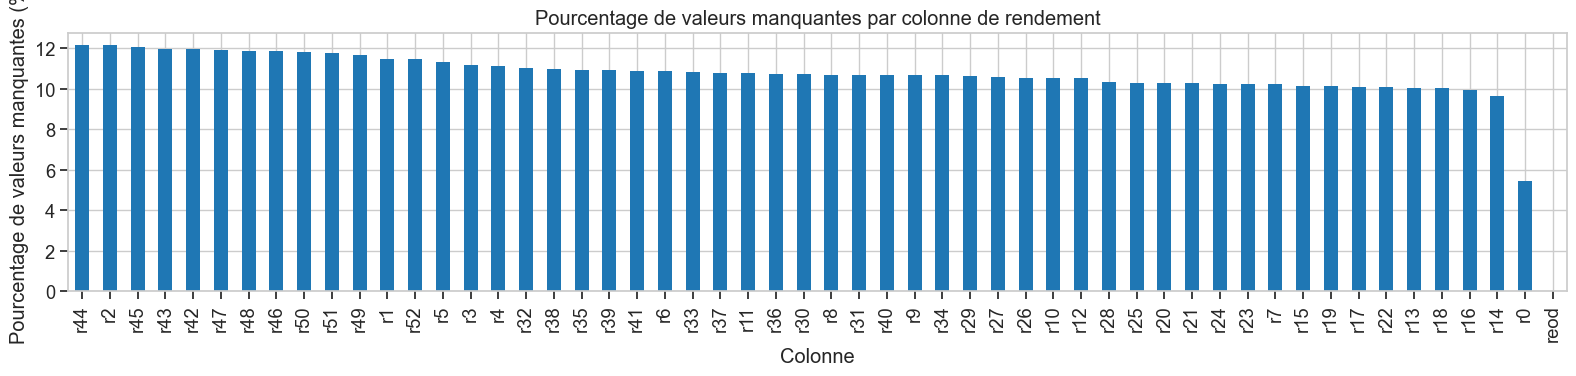

In [57]:
col_rendements = [col for col in X_train.columns if col.startswith("r")]
# Analyse du nombre de valeurs manquantes par colonne
plt.figure(figsize=(16, 4))

missing_values_count = X_train[col_rendements].isna().sum()
missing_values_percent = (missing_values_count / len(X_train)) * 100
missing_df = pd.DataFrame({
    'Nombre de NaN': missing_values_count,
    'Pourcentage (%)': missing_values_percent
}).sort_values('Nombre de NaN', ascending=False)

ax = missing_df['Pourcentage (%)'].plot.bar()
plt.title('Pourcentage de valeurs manquantes par colonne de rendement')
plt.ylabel('Pourcentage de valeurs manquantes (%)')
plt.xlabel('Colonne')
plt.xticks(rotation=90)


plt.tight_layout()
plt.show()

Nombre de lignes totales du dataset: 843299
Nombre de lignes contenant au moins un NaN: 242363, soit 28.74%
Nombre de lignes avec plus de 30% de NaN: 121123, soit 14.36%
Nombre de lignes avec plus de 50% de NaN: 77034, soit 9.13%


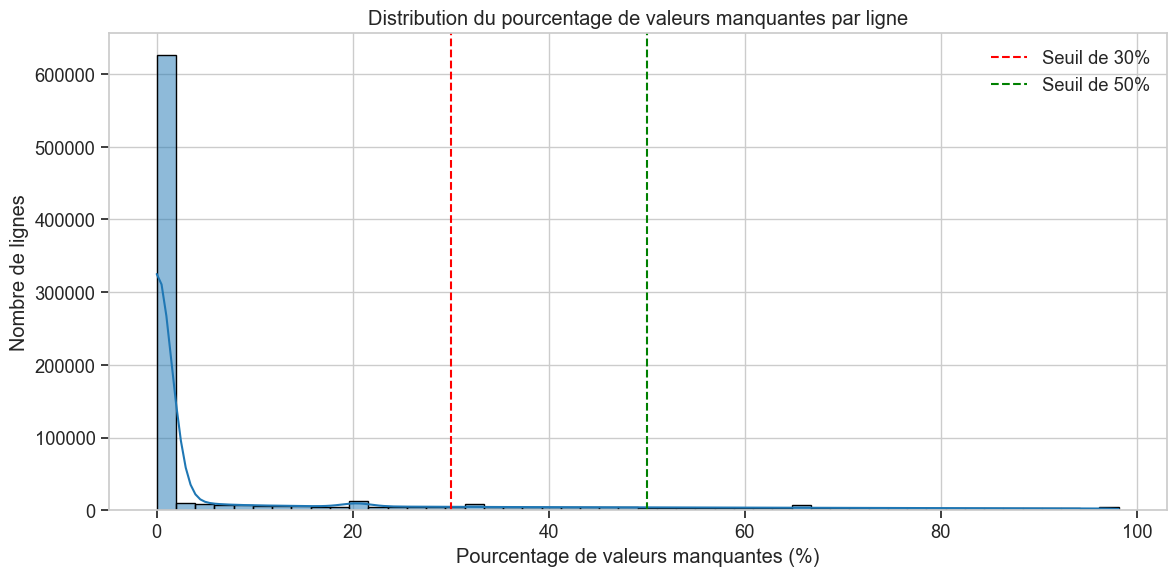

In [58]:
# Analyse du nombre de valeurs manquantes par ligne
NaN_analysis = pd.DataFrame(index=X_train.index, columns=["NaN_count", "NaN_percent"])
NaN_analysis["NaN_count"] = X_train[col_rendements].isna().sum(axis=1)
nombre_colonnes_rend = len(col_rendements)
NaN_analysis["NaN_percent"] = (NaN_analysis["NaN_count"] / nombre_colonnes_rend) * 100

# Compter le nombre de lignes avec des NaN
nbr_row_na = X_train.isna().any(axis=1).sum()

print(f"Nombre de lignes totales du dataset: {len(X_train)}")
print(f"Nombre de lignes contenant au moins un NaN: {nbr_row_na}, soit {(nbr_row_na/len(X_train)*100):.2f}%")
print(f"Nombre de lignes avec plus de 30% de NaN: {len(NaN_analysis[NaN_analysis['NaN_percent']>30])}, soit {len(NaN_analysis[NaN_analysis['NaN_percent']>30])/len(X_train)*100:.2f}%")
print(f"Nombre de lignes avec plus de 50% de NaN: {len(NaN_analysis[NaN_analysis['NaN_percent']>50])}, soit {len(NaN_analysis[NaN_analysis['NaN_percent']>50])/len(X_train)*100:.2f}%")

plt.figure(figsize=(12, 6))
sns.histplot(NaN_analysis["NaN_percent"], bins=50, kde=True)
plt.title('Distribution du pourcentage de valeurs manquantes par ligne')
plt.xlabel('Pourcentage de valeurs manquantes (%)')
plt.ylabel('Nombre de lignes')
plt.axvline(x=30, color='r', linestyle='--', label='Seuil de 30%')
plt.axvline(x=50, color='g', linestyle='--', label='Seuil de 50%')
plt.legend()
plt.tight_layout()
plt.show()

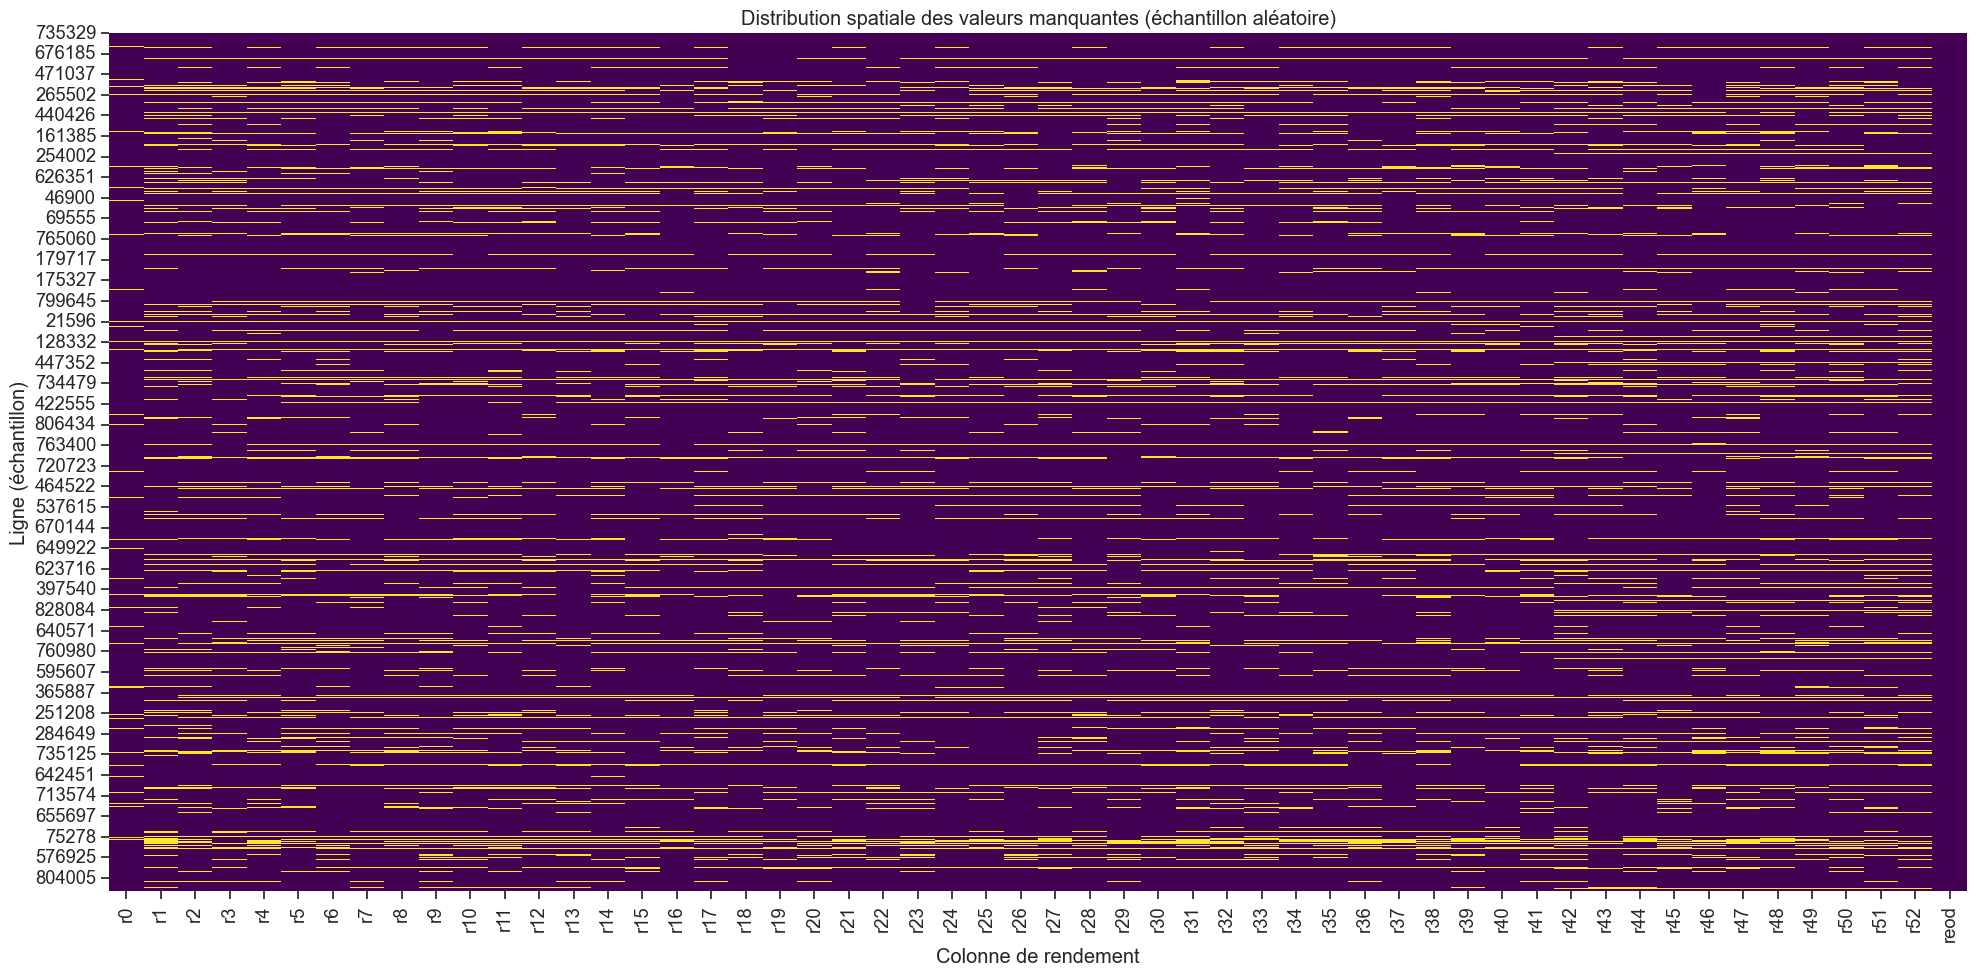

In [59]:
# Distribution spatiale des NaN (heatmap)
plt.figure(figsize=(20, 10))
sample_size = min(1000, len(X_train))  # Limiter à 1000 lignes pour la lisibilité
sample_indices = np.random.choice(range(len(X_train)), sample_size, replace=False)
sample_data = X_train.iloc[sample_indices][col_rendements].isna()
sns.heatmap(sample_data, cbar=False, cmap='viridis')
plt.title('Distribution spatiale des valeurs manquantes (échantillon aléatoire)')
plt.xlabel('Colonne de rendement')
plt.ylabel('Ligne (échantillon)')
plt.tight_layout()
plt.show()


### 2.2 Distribution des rendements

Analysons la distribution des rendements pour identifier d'éventuelles caractéristiques ou anomalies.


In [60]:
col_rendements.remove("reod")

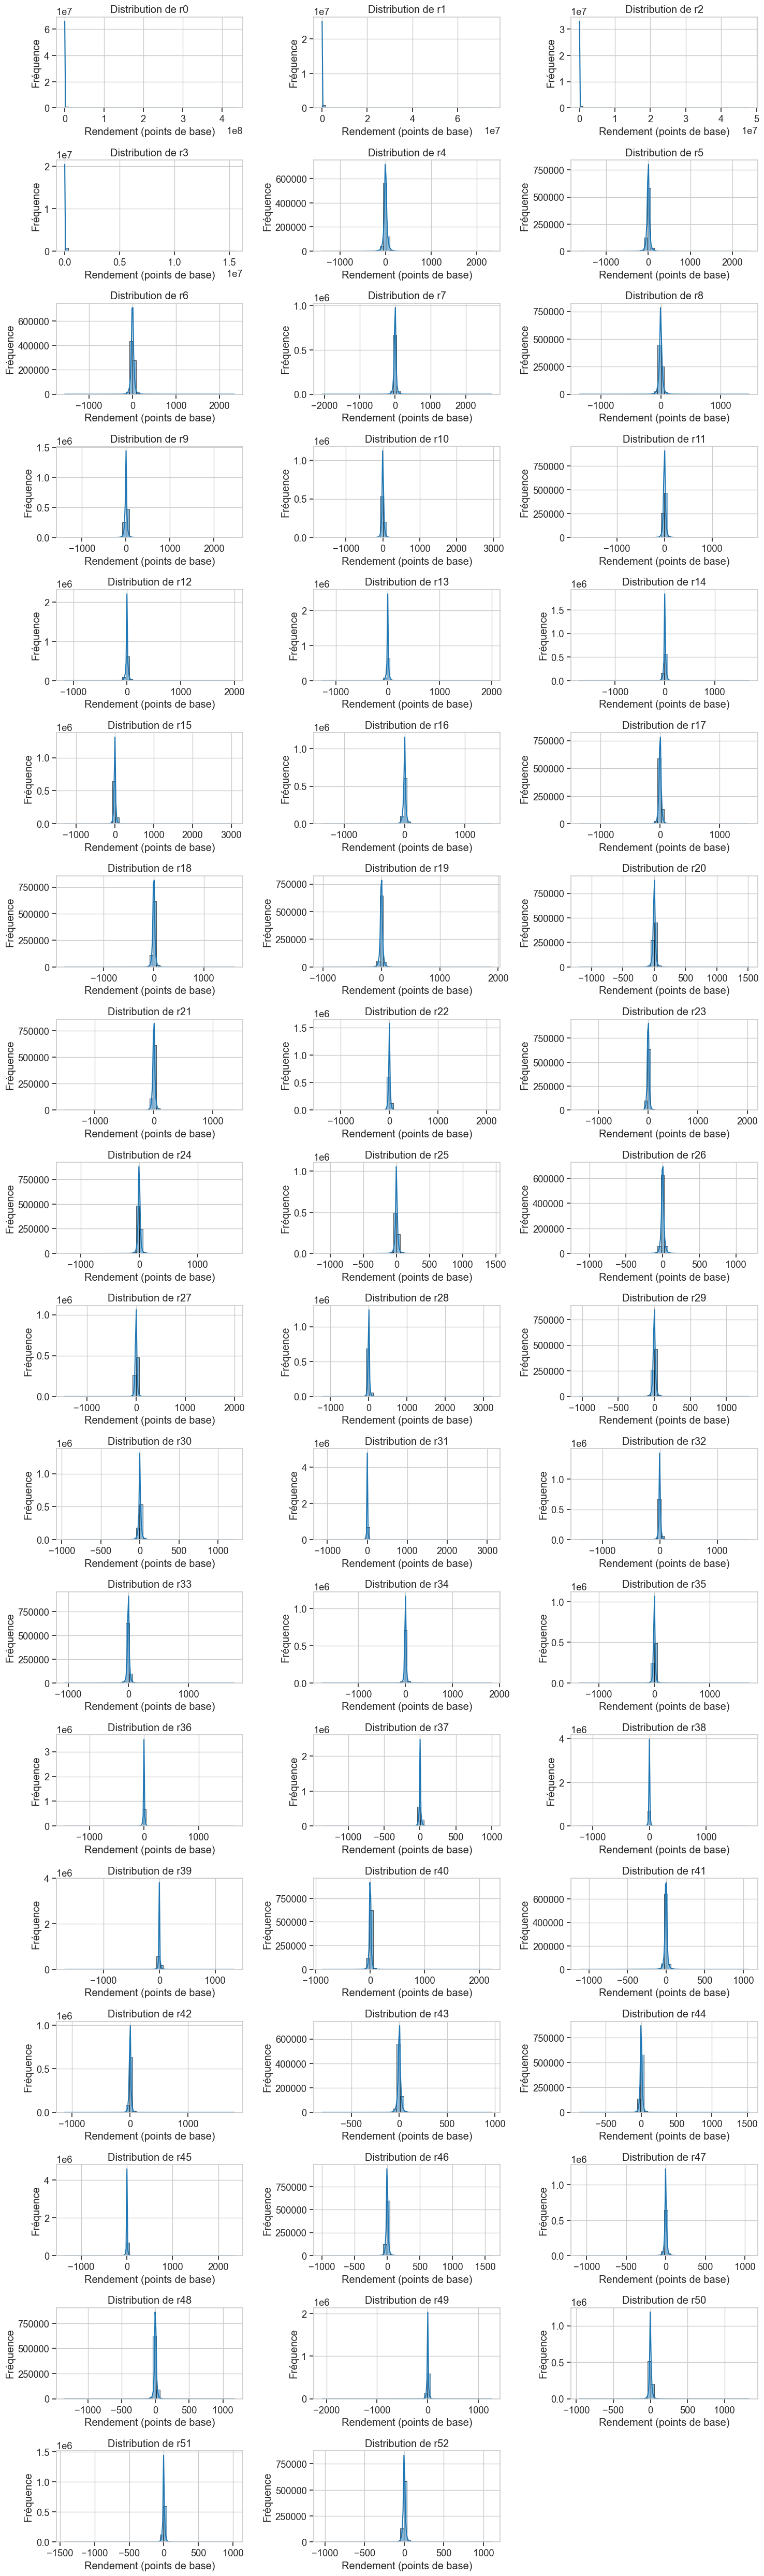

In [61]:
plt.figure(figsize=(15, 50))

for i, col in enumerate(col_rendements):
    plt.subplot(int(len(col_rendements)/3) + 1, 3, i+1)
    sns.histplot(X_train[col].dropna(), kde=True, bins=50)
    plt.title(f'Distribution de {col}')
    plt.xlabel('Rendement (points de base)')
    plt.ylabel('Fréquence')
plt.tight_layout()
plt.show()

In [62]:
rendements_stats = X_train[col_rendements].describe().T
rendements_stats['missing_percent'] = X_train[col_rendements].isna().mean() * 100
rendements_stats = rendements_stats.sort_values('max', ascending=False)
rendements_stats.head(10)

count         mean            std      min    25%  50%    75%  \
r0   797476.0  1839.874545  609754.773378 -9967.67 -30.58  0.0  21.34   
r1   746484.0   193.534369  115327.121385 -9973.54 -21.10  0.0  20.71   
r2   740829.0    70.113991   55888.225790 -4823.74 -17.60  0.0  16.51   
r3   749130.0    19.564481   17850.550113 -1949.69 -17.47  0.0  15.17   
r28  756012.0    -0.270700      24.155237 -1219.51  -7.43  0.0   6.91   
r31  753271.0    -0.098791      23.342380 -1131.26  -6.66  0.0   6.54   
r15  757907.0    -0.625162      29.575757 -1290.32 -10.18  0.0   8.68   
r10  754488.0     0.372729      33.535457 -1647.06 -10.15  0.0  10.76   
r7   757167.0    -1.195195      38.327389 -2066.67 -13.76  0.0  11.44   
r9   753369.0     0.405408      34.341933 -1390.42 -10.34  0.0  11.25   

              max  missing_percent  
r0   4.310700e+08         5.433779  
r1   7.516000e+07        11.480507  
r2   4.789000e+07        12.151088  
r3   1.545000e+07        11.166739  
r28  3.217820e+03        10.350659  
r31  3.114750e+03        10.675692  
r15  3.076920e+03        10.125946  
r10  2.951810e+03        10.531377  
r7   2.733810e+03        10.213696  
r9   2.462310e+03        10.664071

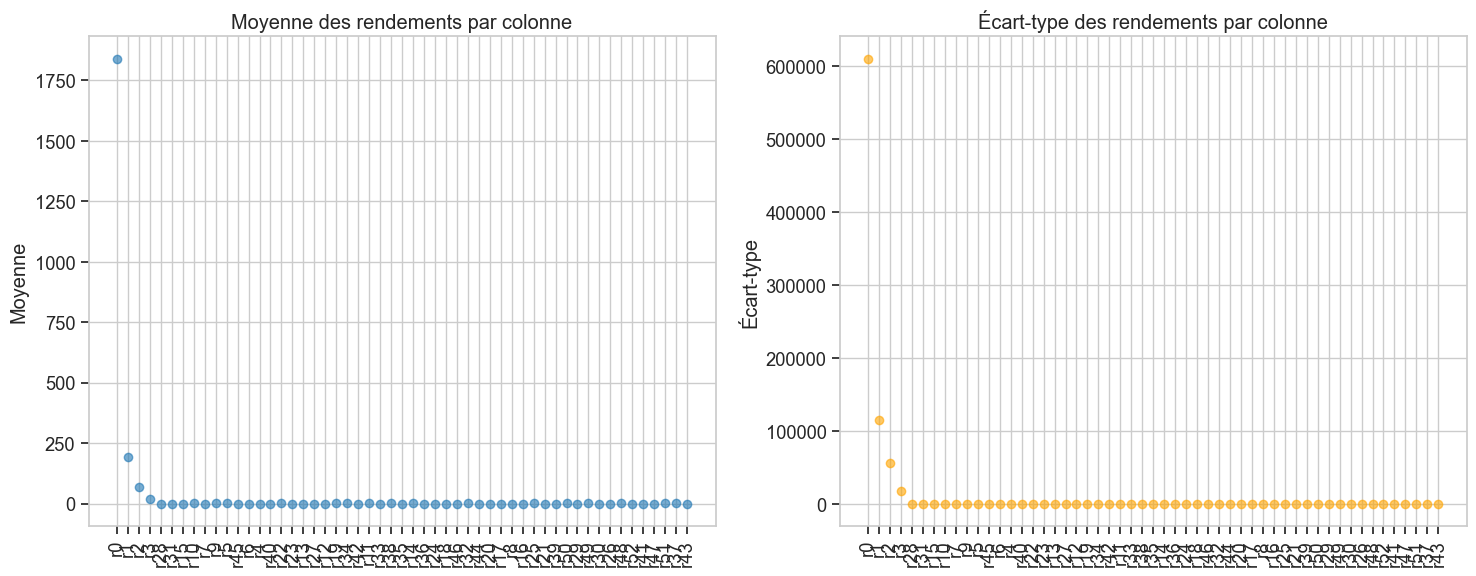

In [63]:
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.scatter(rendements_stats.index, rendements_stats['mean'], alpha=0.6)
plt.title('Moyenne des rendements par colonne')
plt.xticks(rotation=90)
plt.ylabel('Moyenne')

plt.subplot(1, 2, 2)
plt.scatter(rendements_stats.index, rendements_stats['std'], alpha=0.6, color='orange')
plt.title('Écart-type des rendements par colonne')
plt.xticks(rotation=90)
plt.ylabel('Écart-type')
plt.tight_layout()
plt.show()


### 2.3 Analyse de la variable cible

Examinons la distribution de notre variable cible `reod` pour vérifier l'équilibre entre les classes.


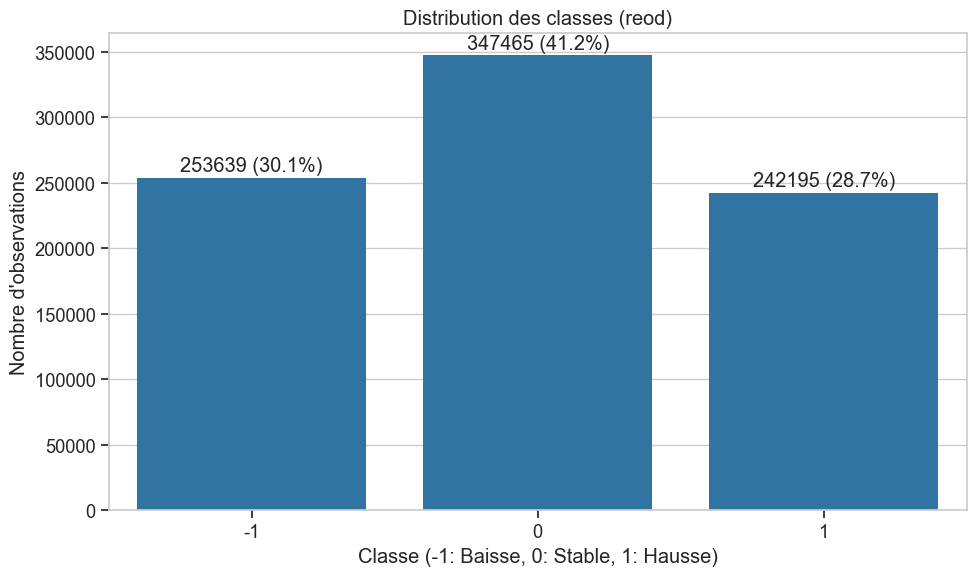

In [64]:
# Distribution des classes
plt.figure(figsize=(10, 6))

class_counts = X_train['reod'].value_counts().sort_index()
ax = sns.barplot(x=class_counts.index, y=class_counts.values)

plt.title('Distribution des classes (reod)')
plt.xlabel('Classe (-1: Baisse, 0: Stable, 1: Hausse)')
plt.ylabel('Nombre d\'observations')

total = len(X_train)
for i, v in enumerate(class_counts):
    ax.text(i, v + 5000, f'{v} ({v/total*100:.1f}%)', ha='center')
    
plt.tight_layout()
plt.show()


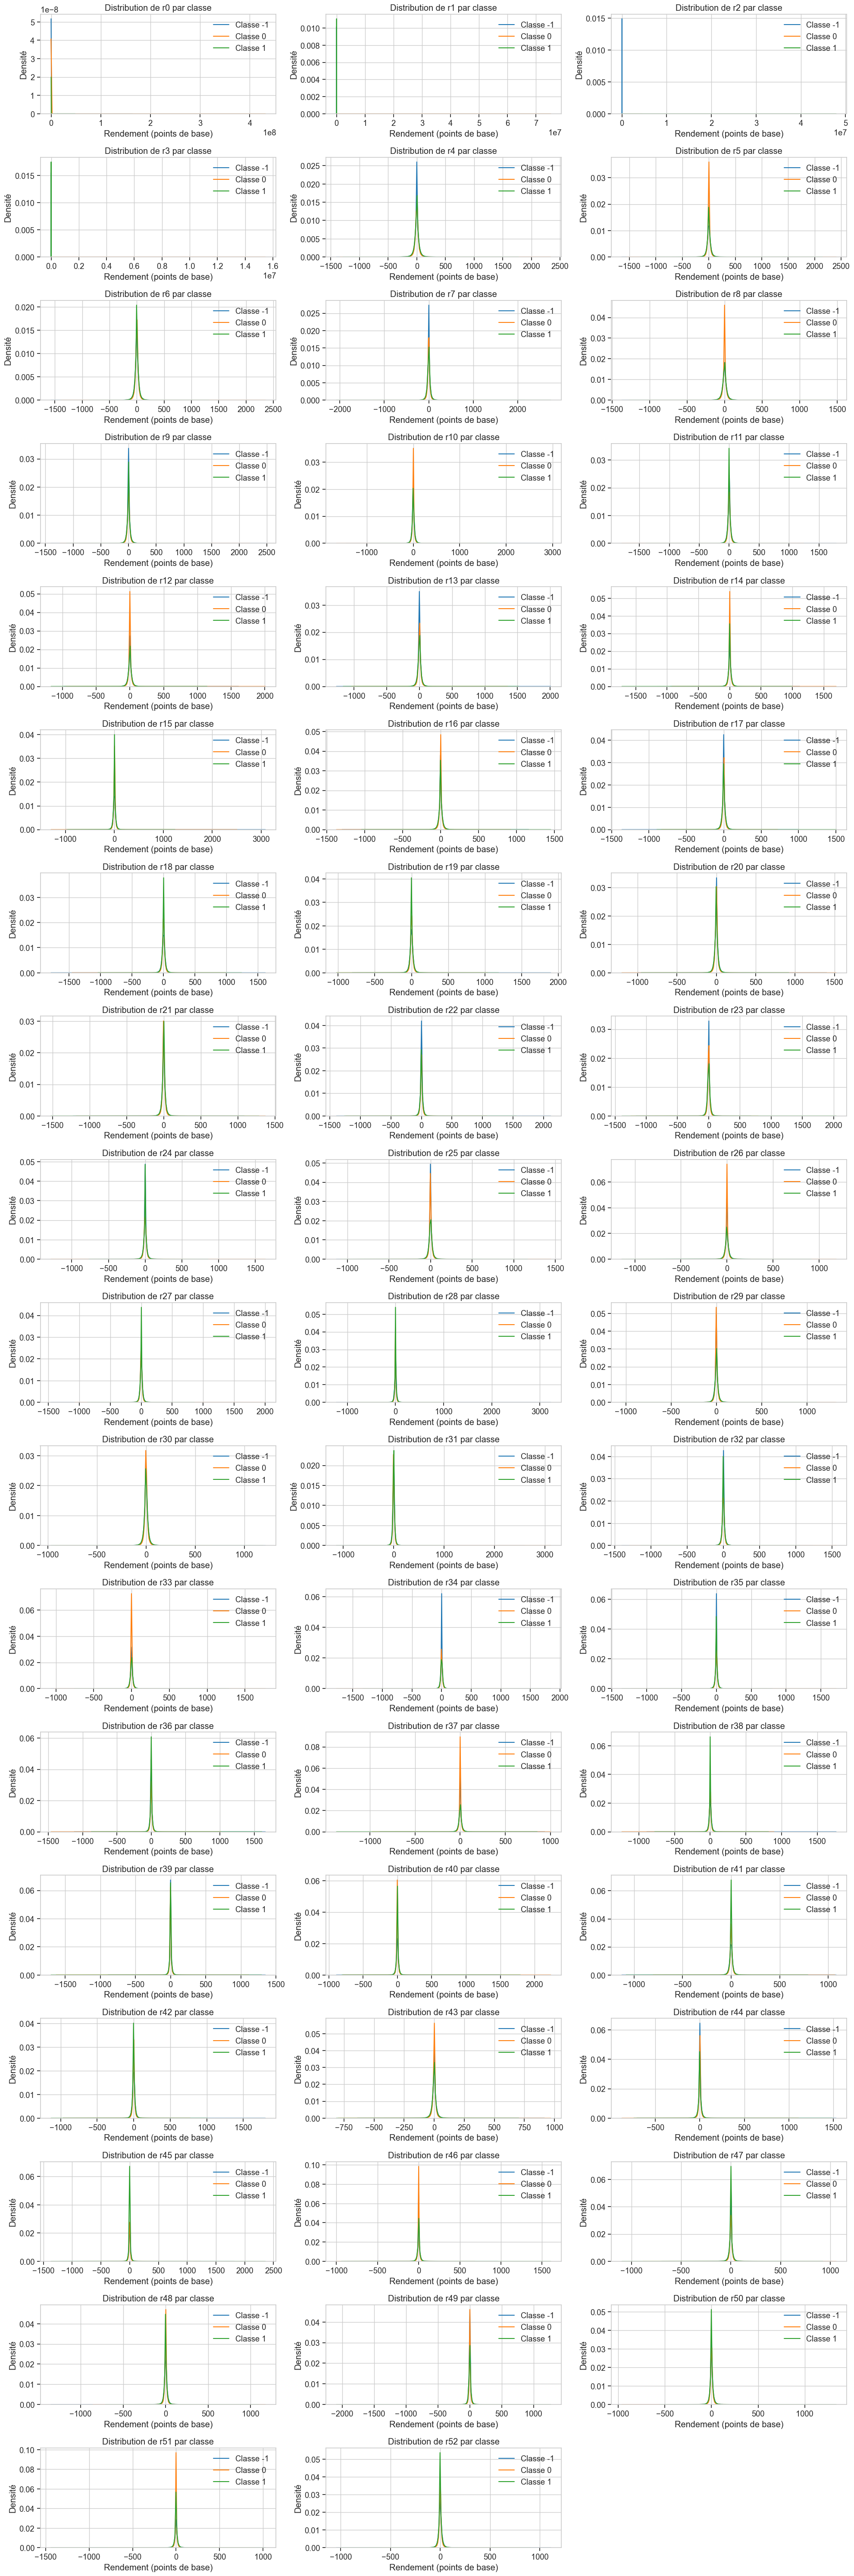

In [65]:
# Analyse des rendements par classe
plt.figure(figsize=(20,60))

for i, col in enumerate(col_rendements):
    
    plt.subplot(int(len(col_rendements)/3) + 1, 3, i+1)
    for cls in sorted(X_train['reod'].unique()):
        subset = X_train[X_train['reod'] == cls][col].dropna()
        sns.kdeplot(subset, label=f'Classe {cls}')
    plt.title(f'Distribution de {col} par classe')
    plt.xlabel('Rendement (points de base)')
    plt.ylabel('Densité')
    plt.legend()
    
plt.tight_layout()
plt.show()

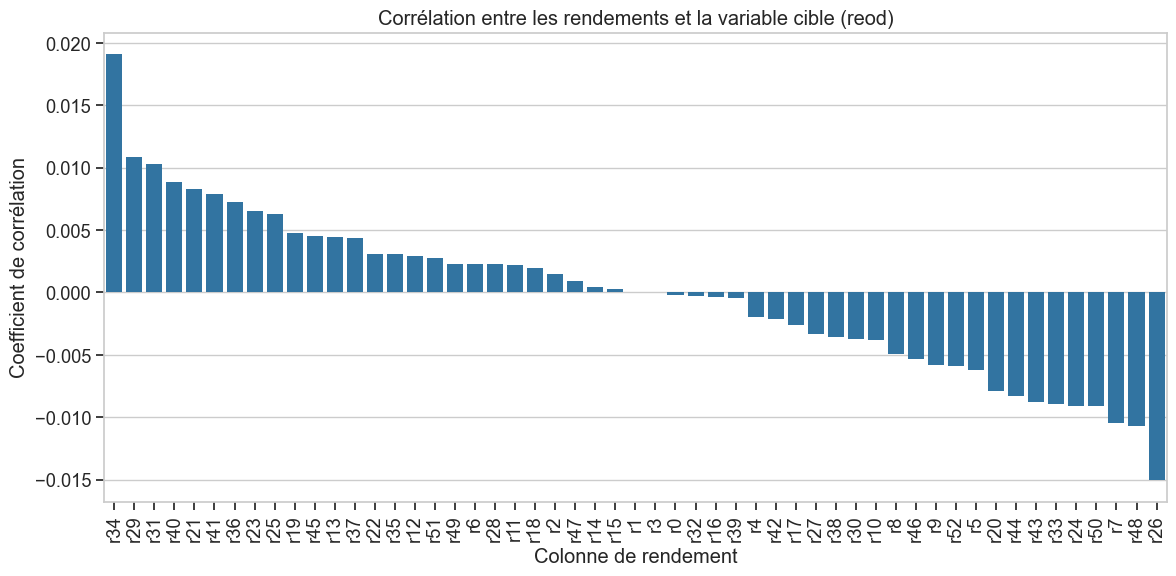

Top 5 des rendements positivement corrélés avec reod:


r34    0.019112
r29    0.010815
r31    0.010292
r40    0.008857
r21    0.008309
Name: reod, dtype: float64


Top 5 des rendements négativement corrélés avec reod:


r24   -0.009070
r50   -0.009138
r7    -0.010481
r48   -0.010694
r26   -0.015045
Name: reod, dtype: float64

In [66]:
# Corrélation entre les rendements et la variable cible
correlations = X_train[col_rendements + ['reod']].corr()['reod'].drop('reod').sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=correlations.index, y=correlations.values)
plt.title('Corrélation entre les rendements et la variable cible (reod)')
plt.xticks(rotation=90)
plt.xlabel('Colonne de rendement')
plt.ylabel('Coefficient de corrélation')
plt.tight_layout()
plt.show()

print("Top 5 des rendements positivement corrélés avec reod:")
display(correlations.head())

print("\nTop 5 des rendements négativement corrélés avec reod:")
display(correlations.tail())

## 3. Stratégies d'imputation

Face au défi des valeurs manquantes, nous testons plusieurs stratégies d'imputation pour compléter les données.

- 1 :  Forward-fill puis backward-fill (FFBF)

Cette stratégie propage d'abord les dernières valeurs connues vers l'avant, puis remplit les valeurs restantes en propageant depuis la fin.|

- 2 : Backward-fill puis forward-fill (BFFF)

Cette stratégie inverse commence par propager depuis la fin, puis remplit les valeurs restantes en propageant depuis le début.


- 3 : Interpolation linéaire

Cette méthode crée une ligne droite entre les valeurs connues pour estimer les valeurs manquantes.

- 4 : Imputation par K plus proches voisins (KNN)

Cette méthode utilise les K observations les plus similaires pour estimer les valeurs manquantes.

- 5 : MICE 


In [3]:
from utils.data_registry import DATASETS
from utils.features import add_features
from utils.benchmarks import get_models
from utils.experiment_runner import run_experiment, display_experiment_result, add_result
from utils.load_data import load_datasets
from utils.graphic import analyze_distributions, compare_column_stats, analyze_normalization
from utils.variance_analysis import perform_pca_analysis, perform_tsne_analysis, analyze_correlations, evaluate_feature_sets, analyze_feature_importance, select_best_features, summarize_feature_analysis

# Create empty results tracker
results_tracker = pd.DataFrame(columns=[
    "dataset", "dataset_description", "model", "model_description", 
    "features_added", "feature_sets", "accuracy", "precision_weighted", 
    "recall_weighted", "f1_weighted"
])

# Charger les datasets
imputed_datasets = load_datasets()


Chargement du dataset raw...
Temps de chargement: 7.54 secondes
Dimensions train: (730784, 57), test: (857641, 57)
Valeurs manquantes - train: 969666, test: 512130

Distribution des classes dans le dataset d'entraînement:
  Classe 0: 36.55%
  Classe -1: 32.42%
  Classe 1: 31.03%

Chargement du dataset ffbf...
Temps de chargement: 7.31 secondes
Dimensions train: (730784, 57), test: (857641, 57)
Valeurs manquantes - train: 0, test: 0

Distribution des classes dans le dataset d'entraînement:
  Classe 0: 36.55%
  Classe -1: 32.42%
  Classe 1: 31.03%

Chargement du dataset bfff...
Temps de chargement: 7.20 secondes
Dimensions train: (730784, 57), test: (857641, 57)
Valeurs manquantes - train: 0, test: 0

Distribution des classes dans le dataset d'entraînement:
  Classe 0: 36.55%
  Classe -1: 32.42%
  Classe 1: 31.03%

Chargement du dataset interp...
Temps de chargement: 7.51 secondes
Dimensions train: (730784, 57), test: (857641, 57)
Valeurs manquantes - train: 0, test: 0

Distribution des

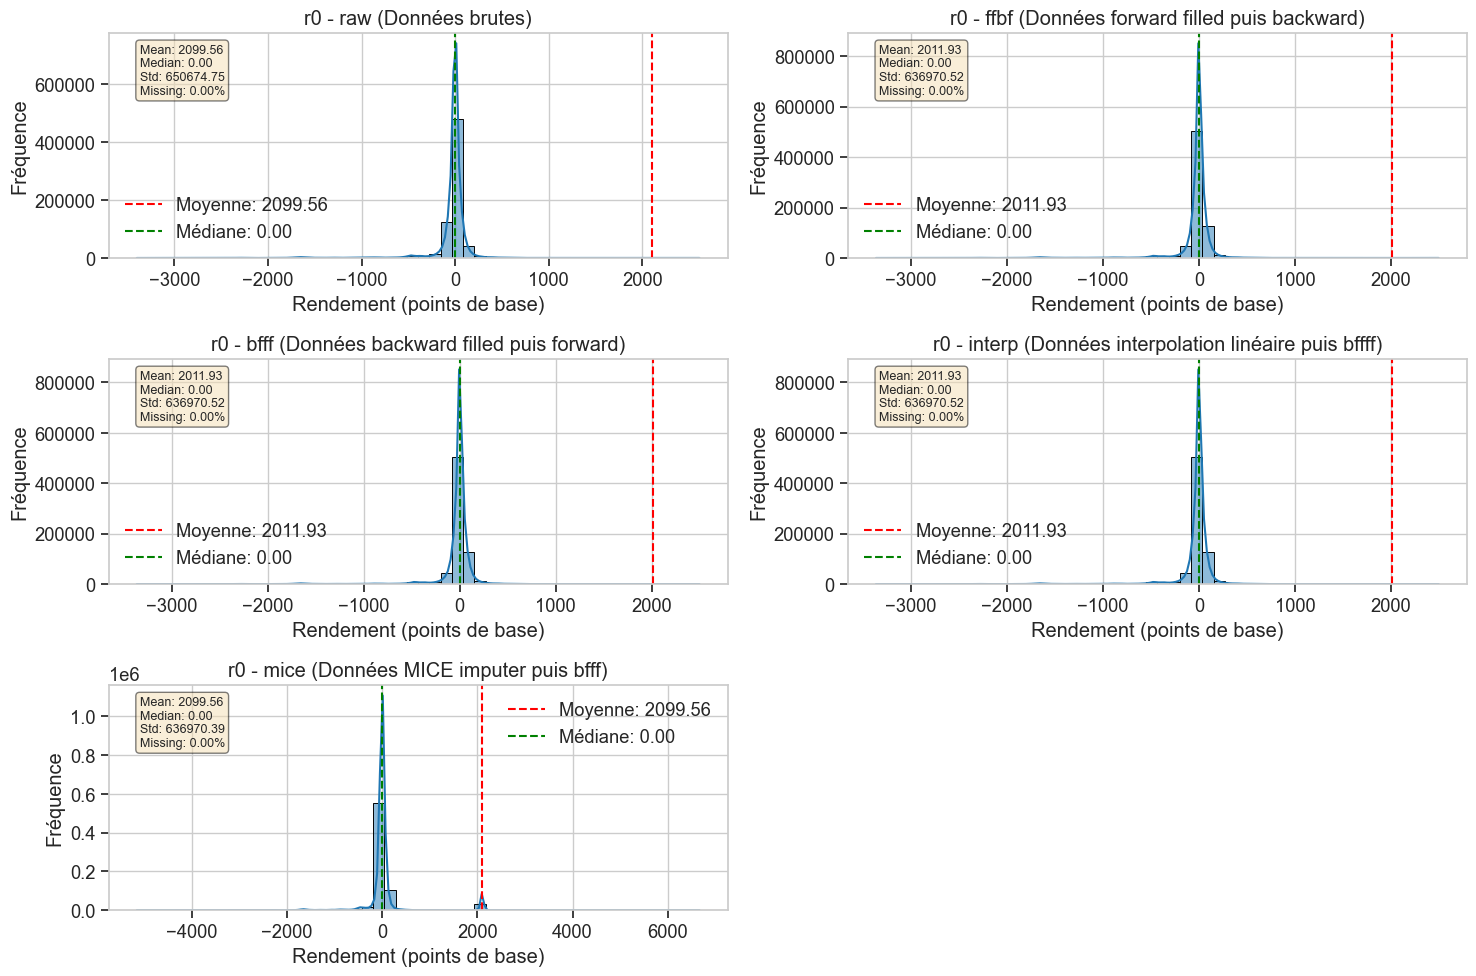

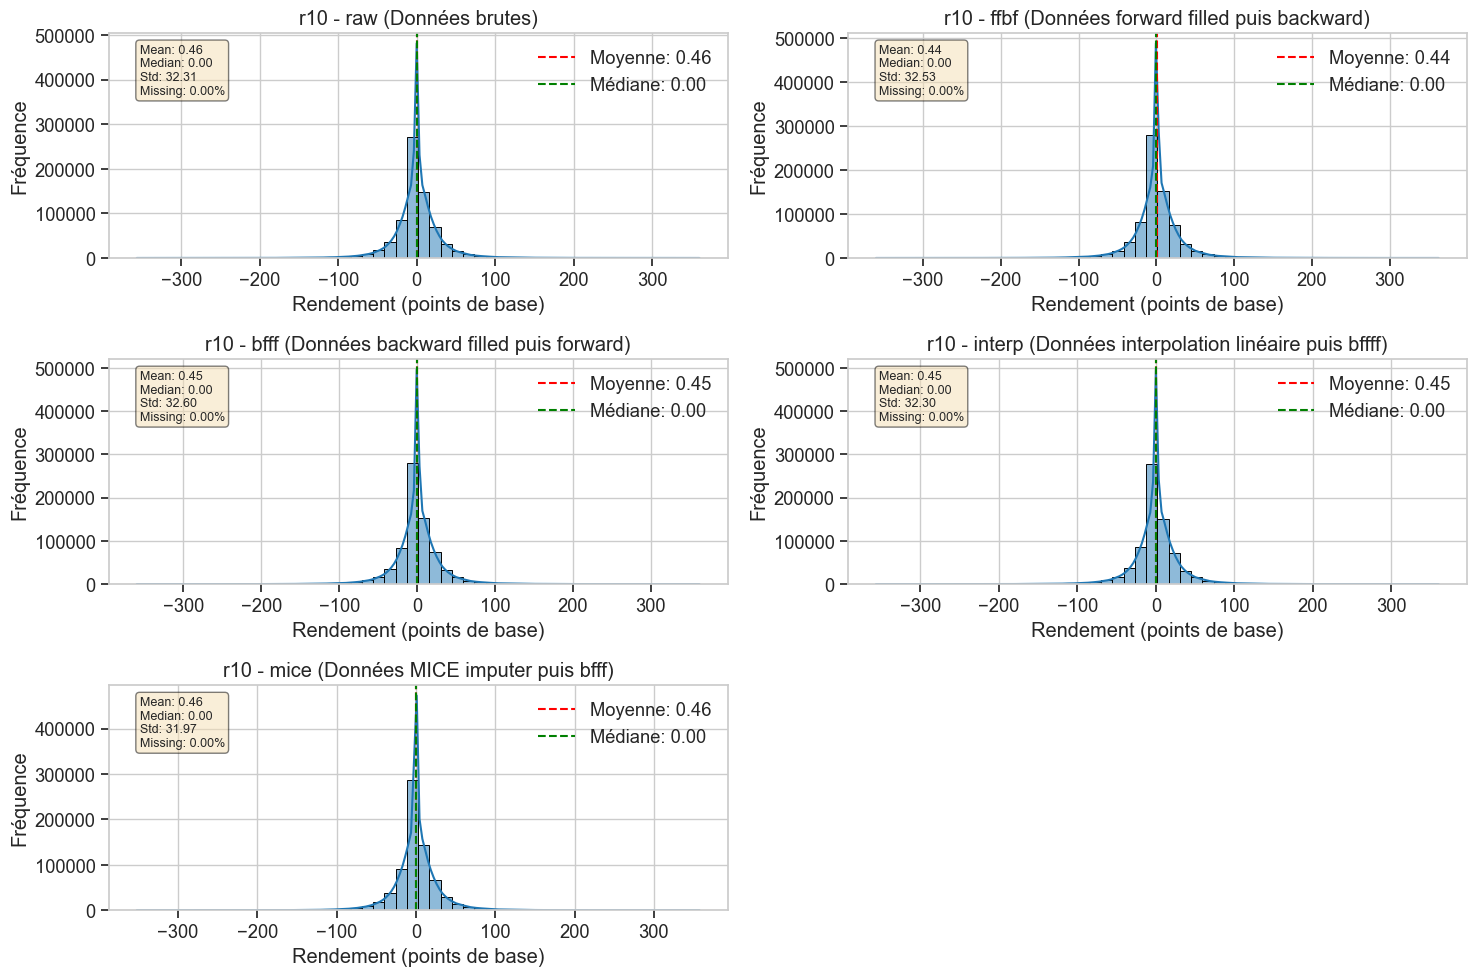

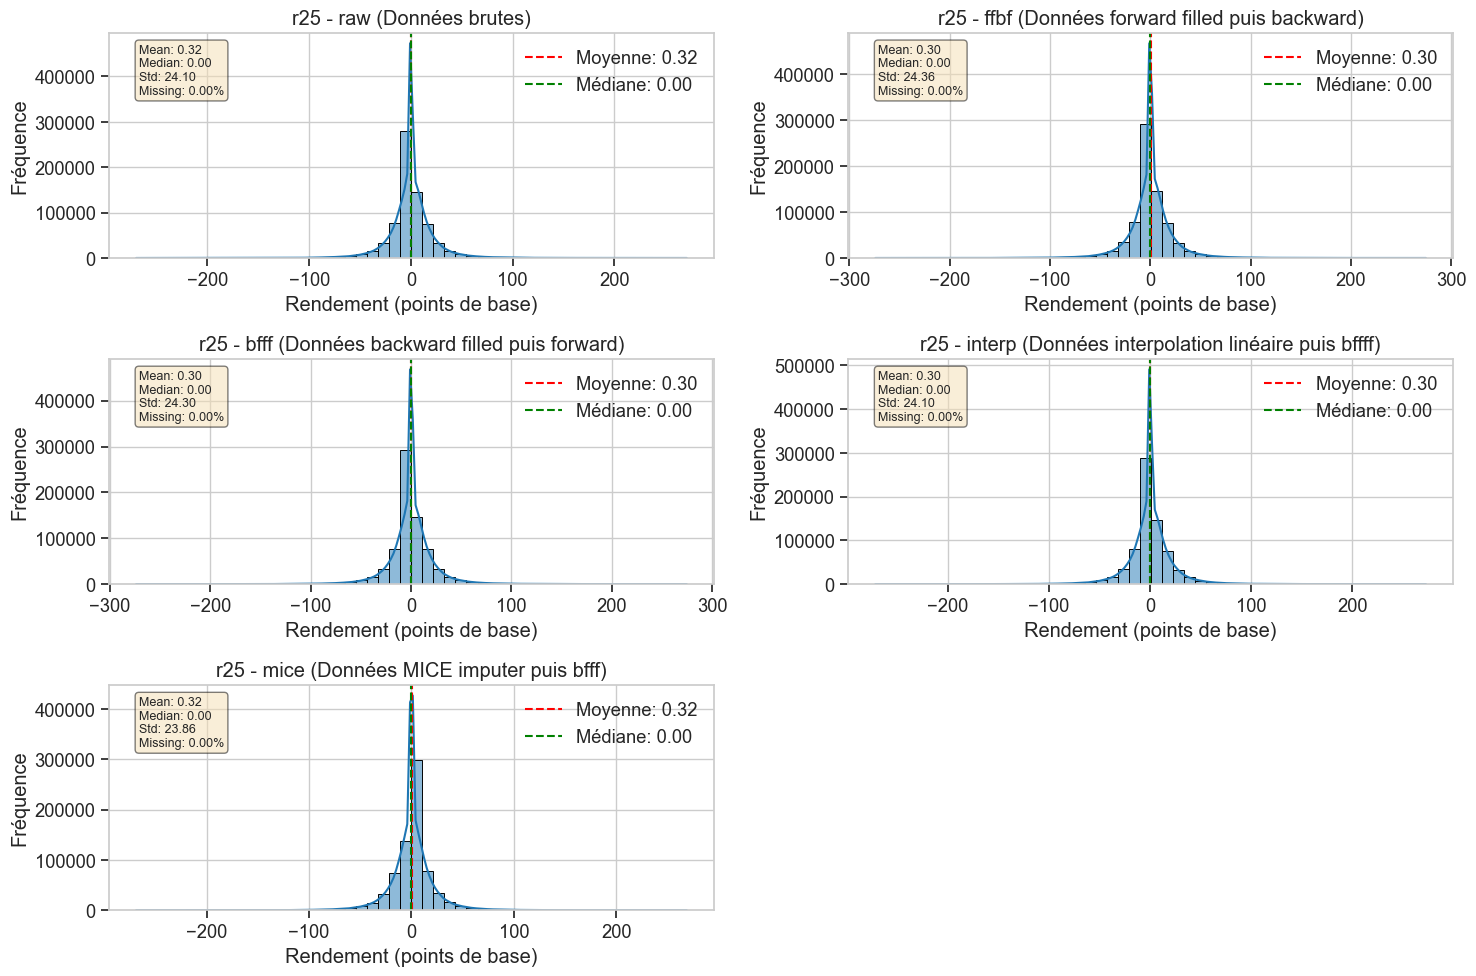

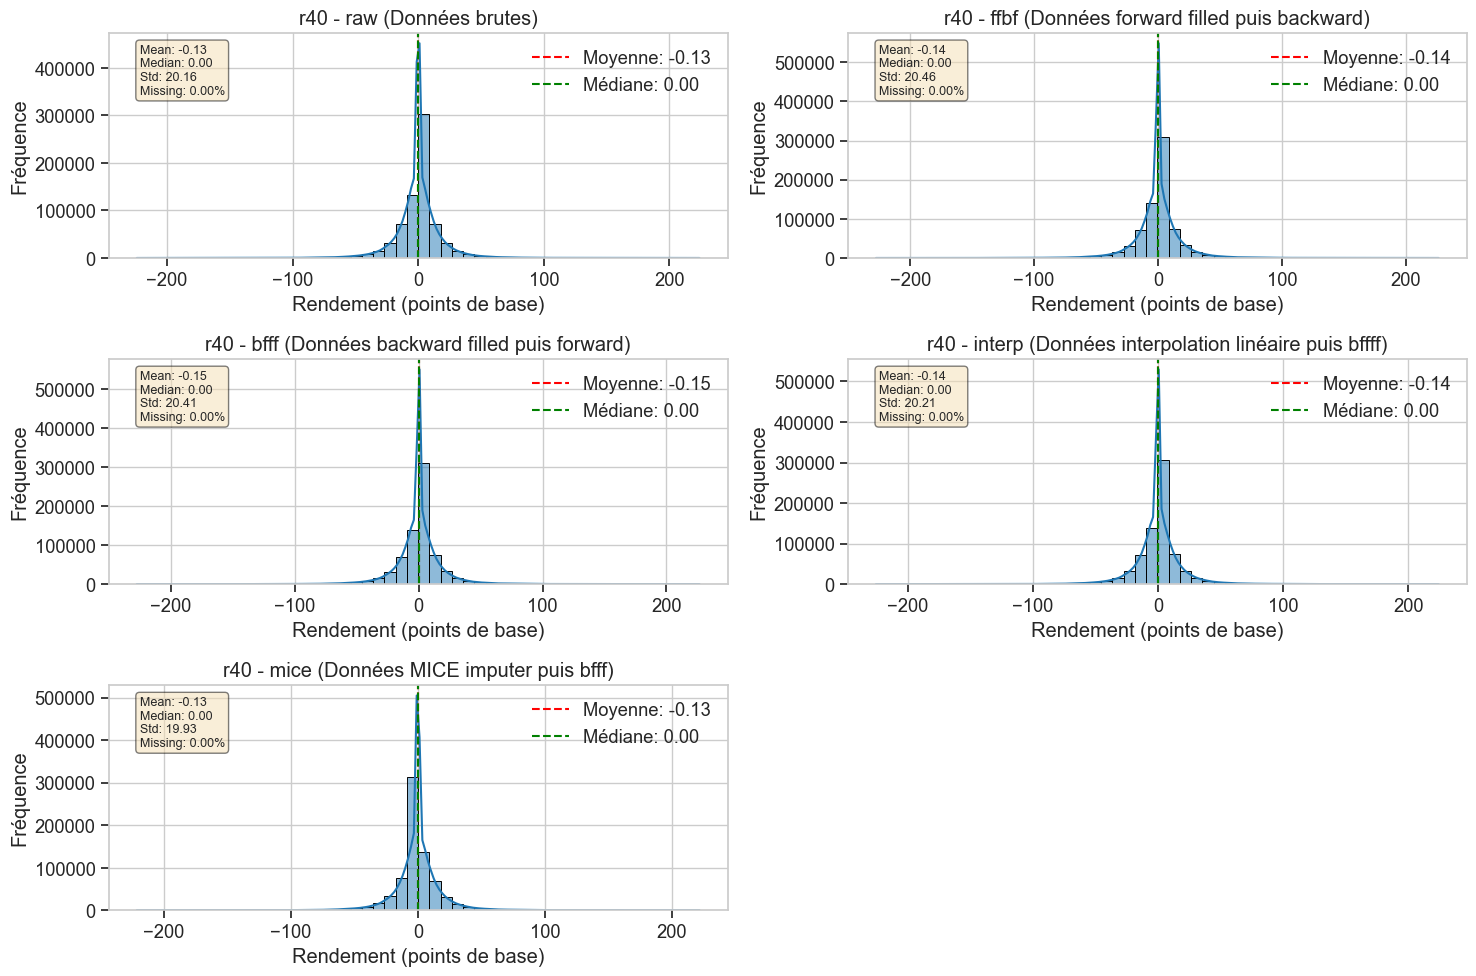

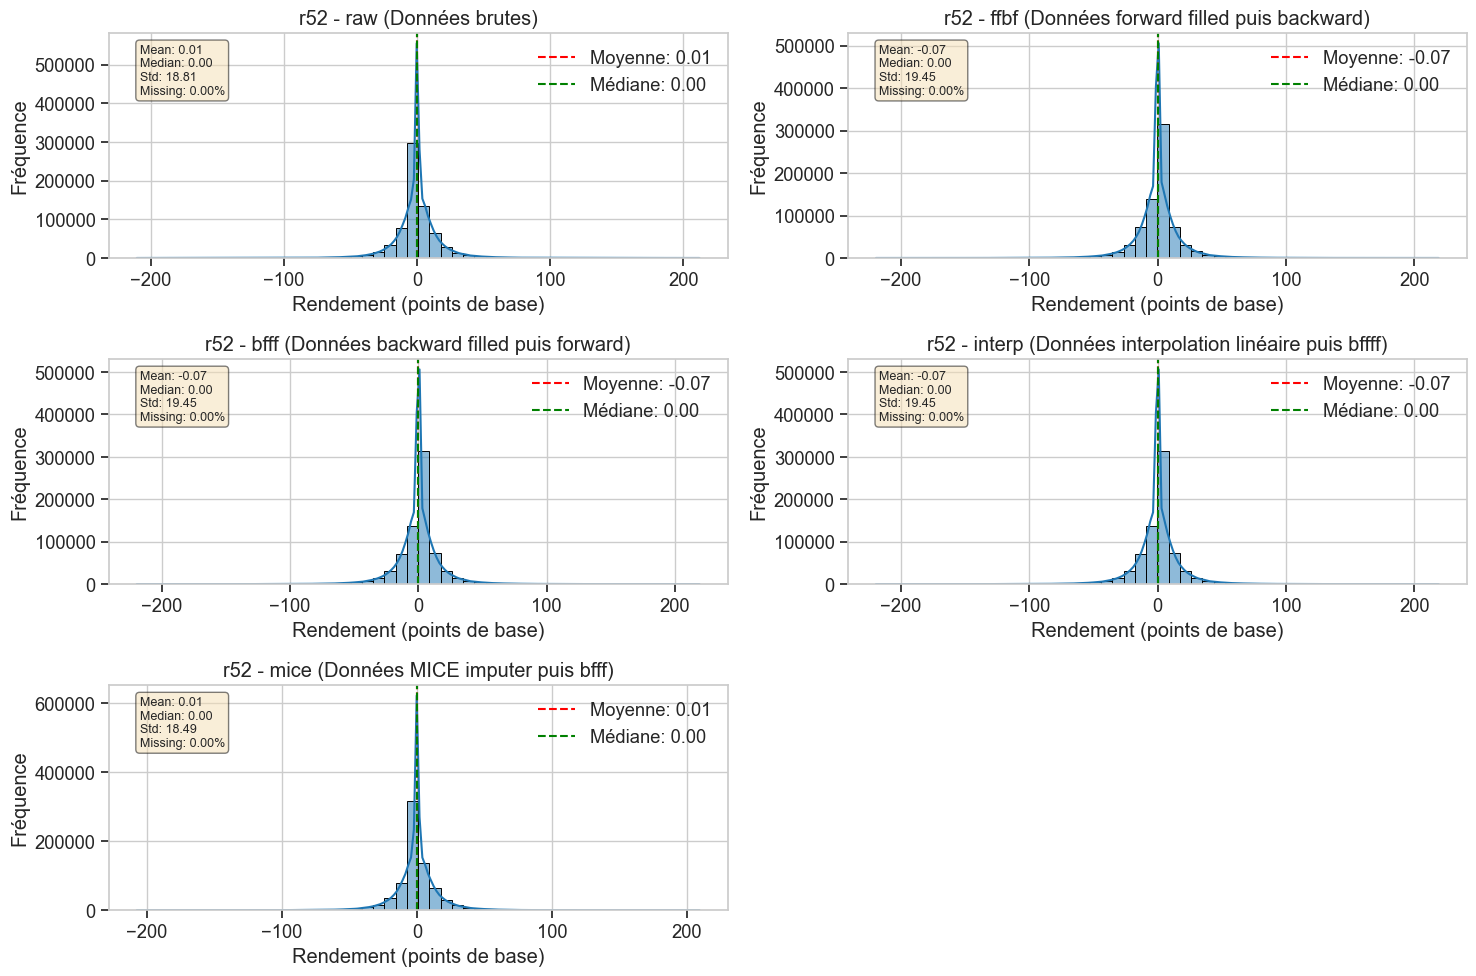

In [4]:
analyze_distributions(imputed_datasets)


### 3.2 Comparaison des stratégies d'imputation

Nous comparons les distributions après imputation pour évaluer l'impact de chaque méthode.


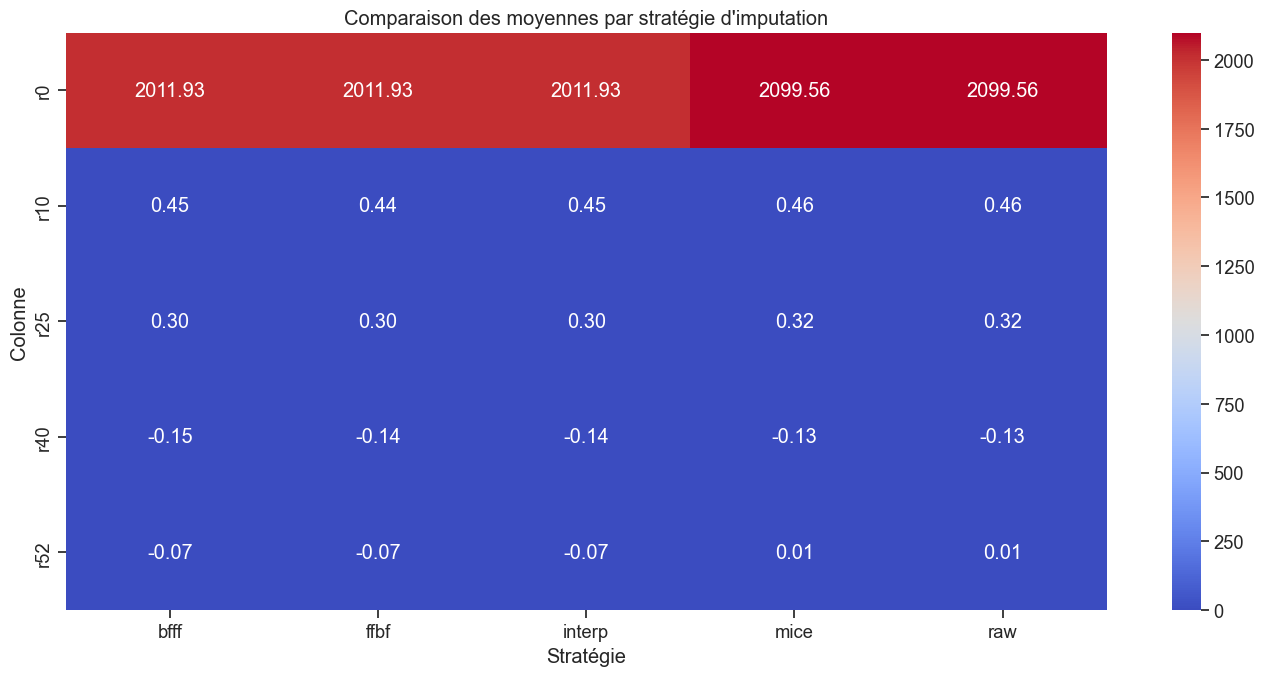

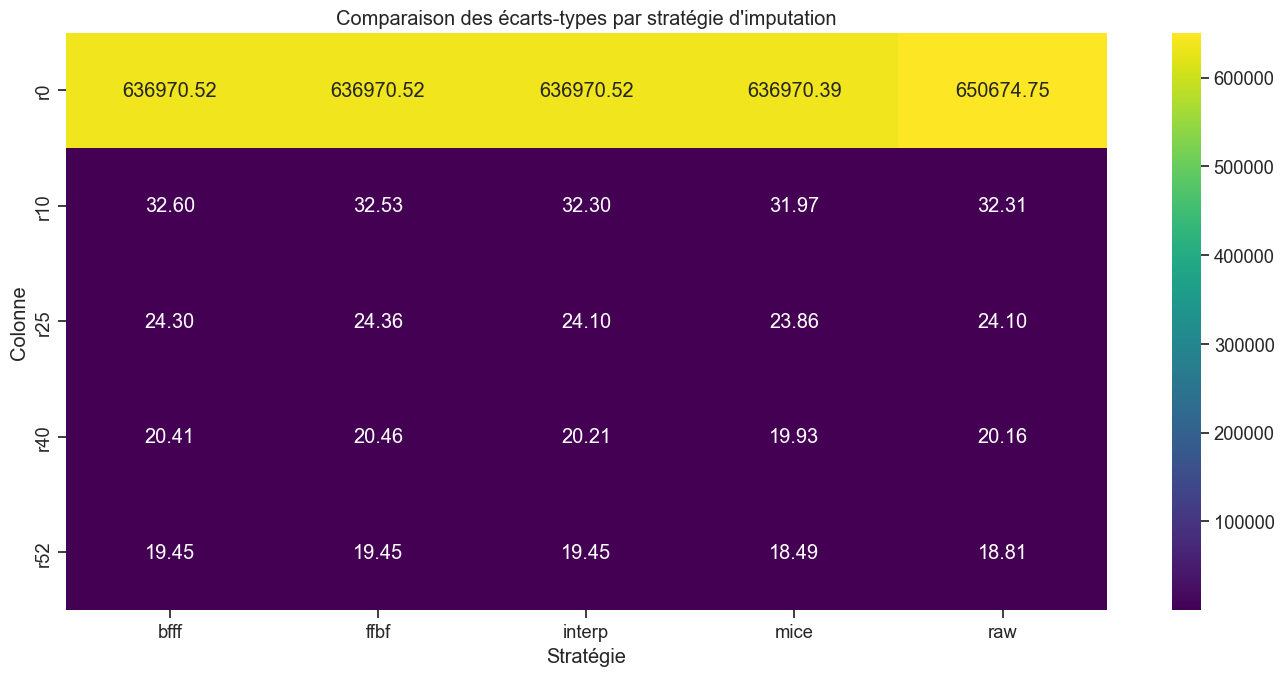

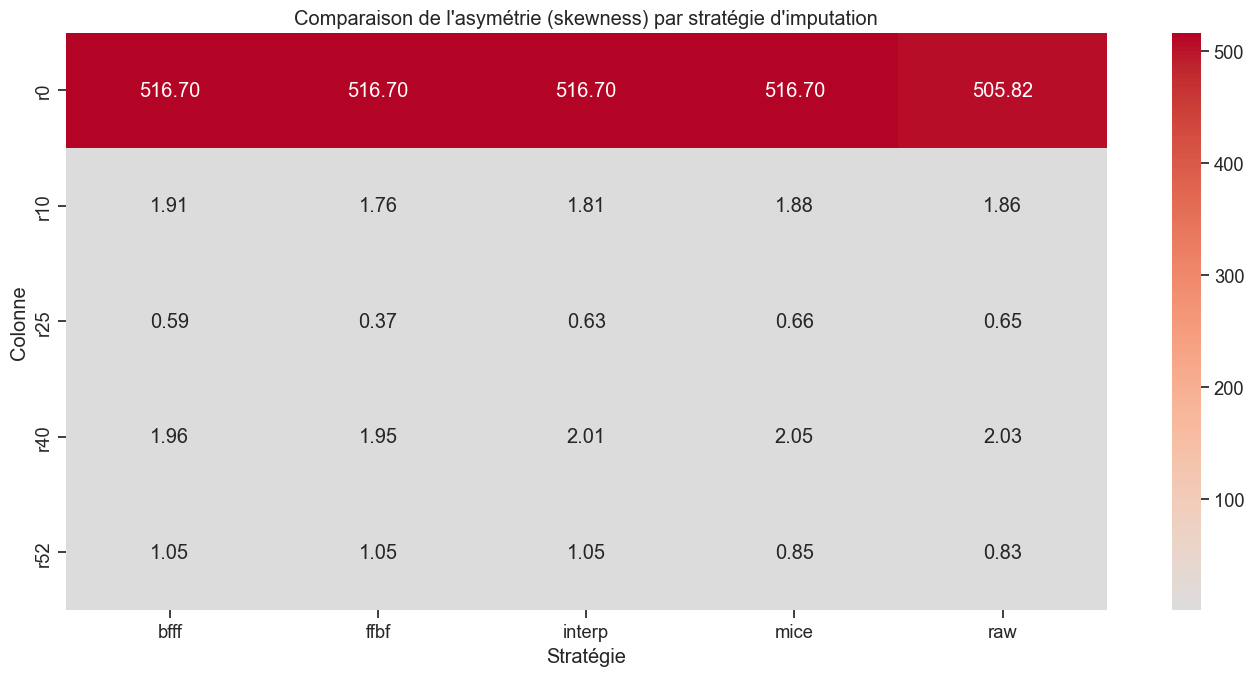

In [5]:
stats_results = compare_column_stats(imputed_datasets)

### 3.3 Différentes méthodes de normalisation : 

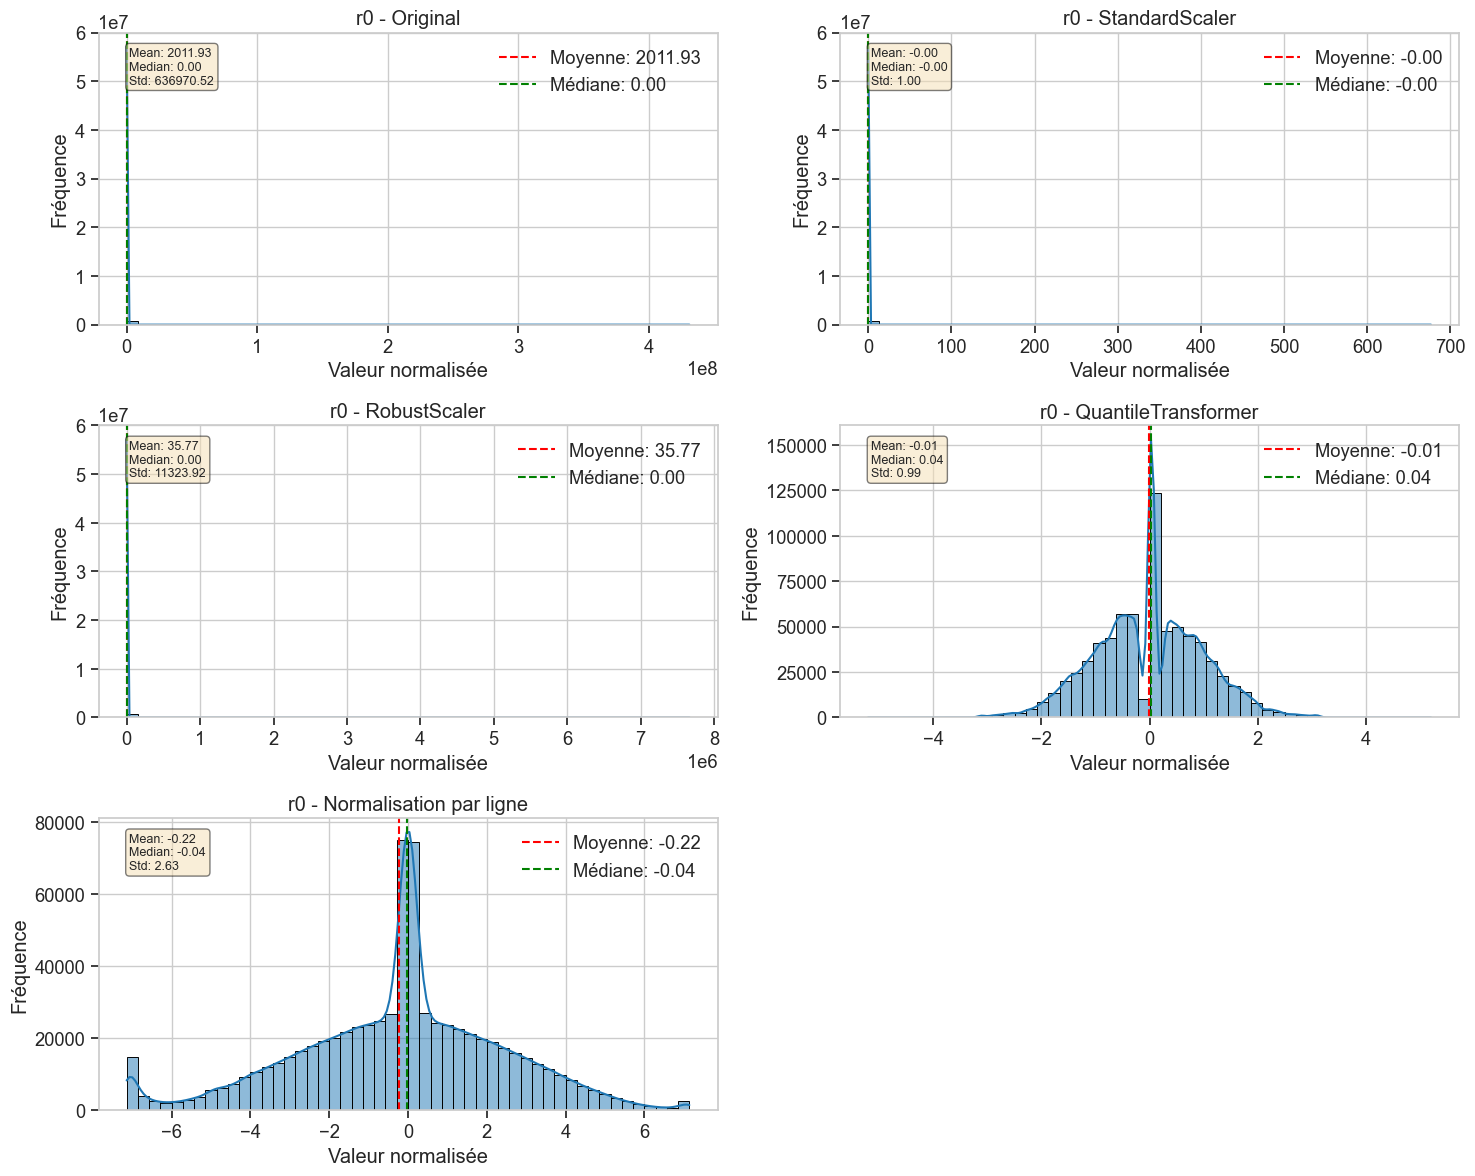

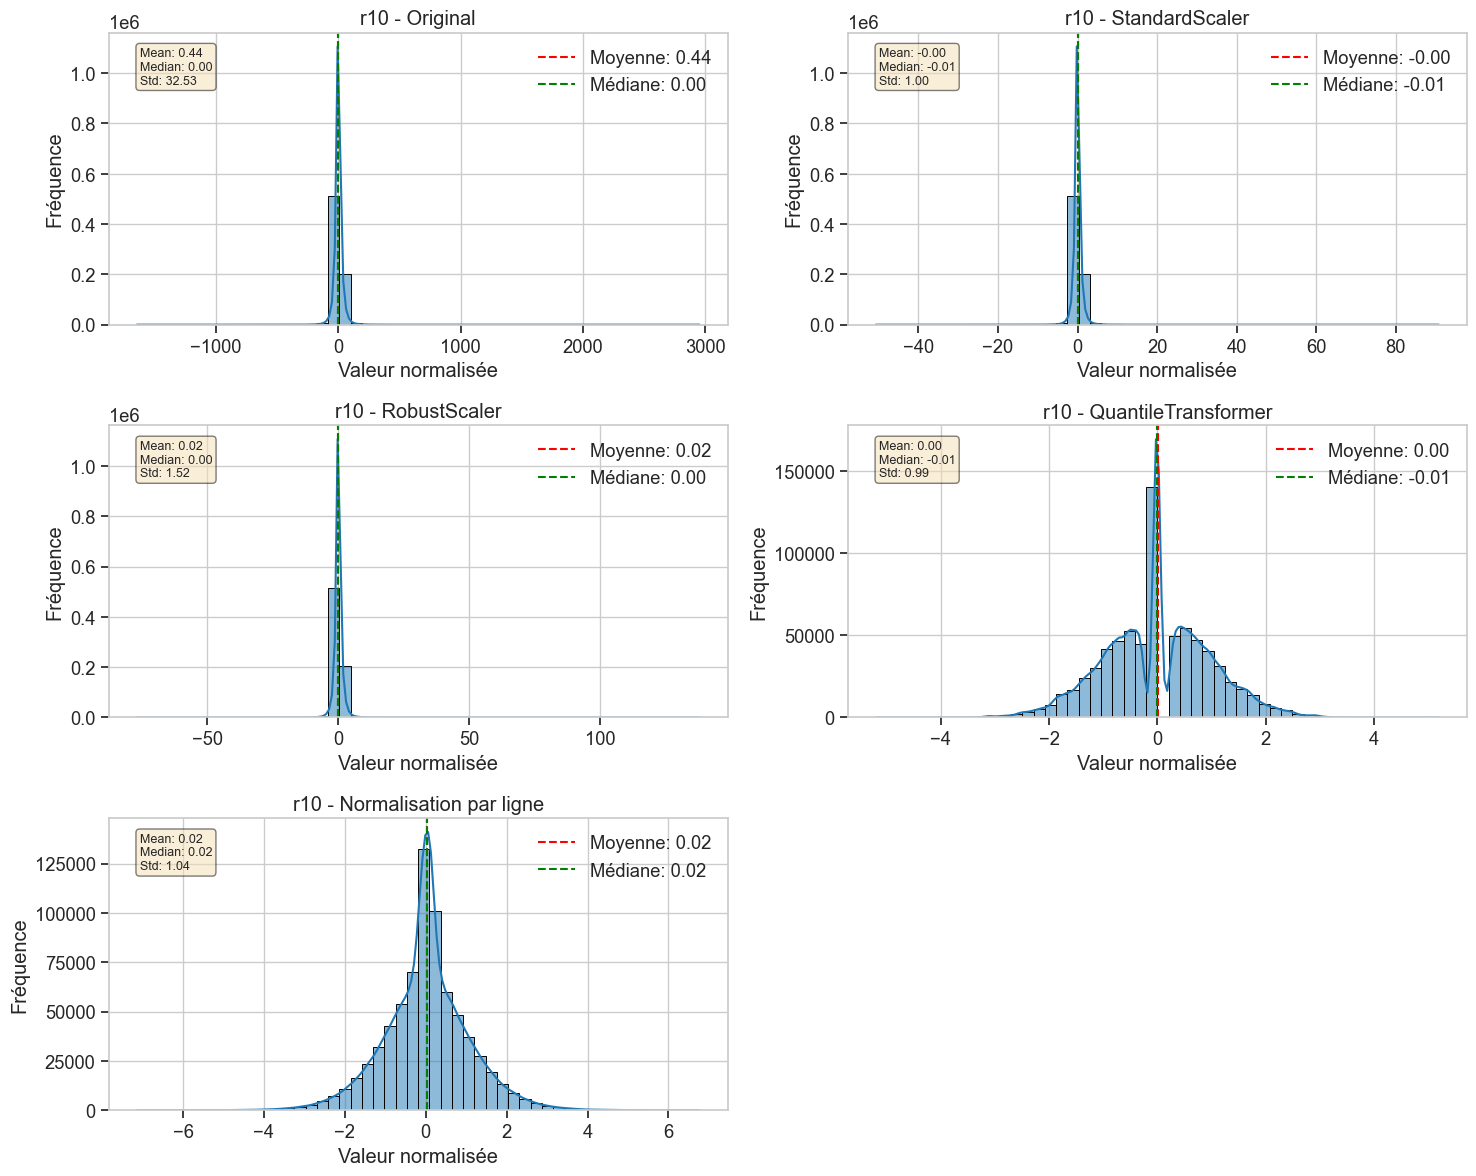

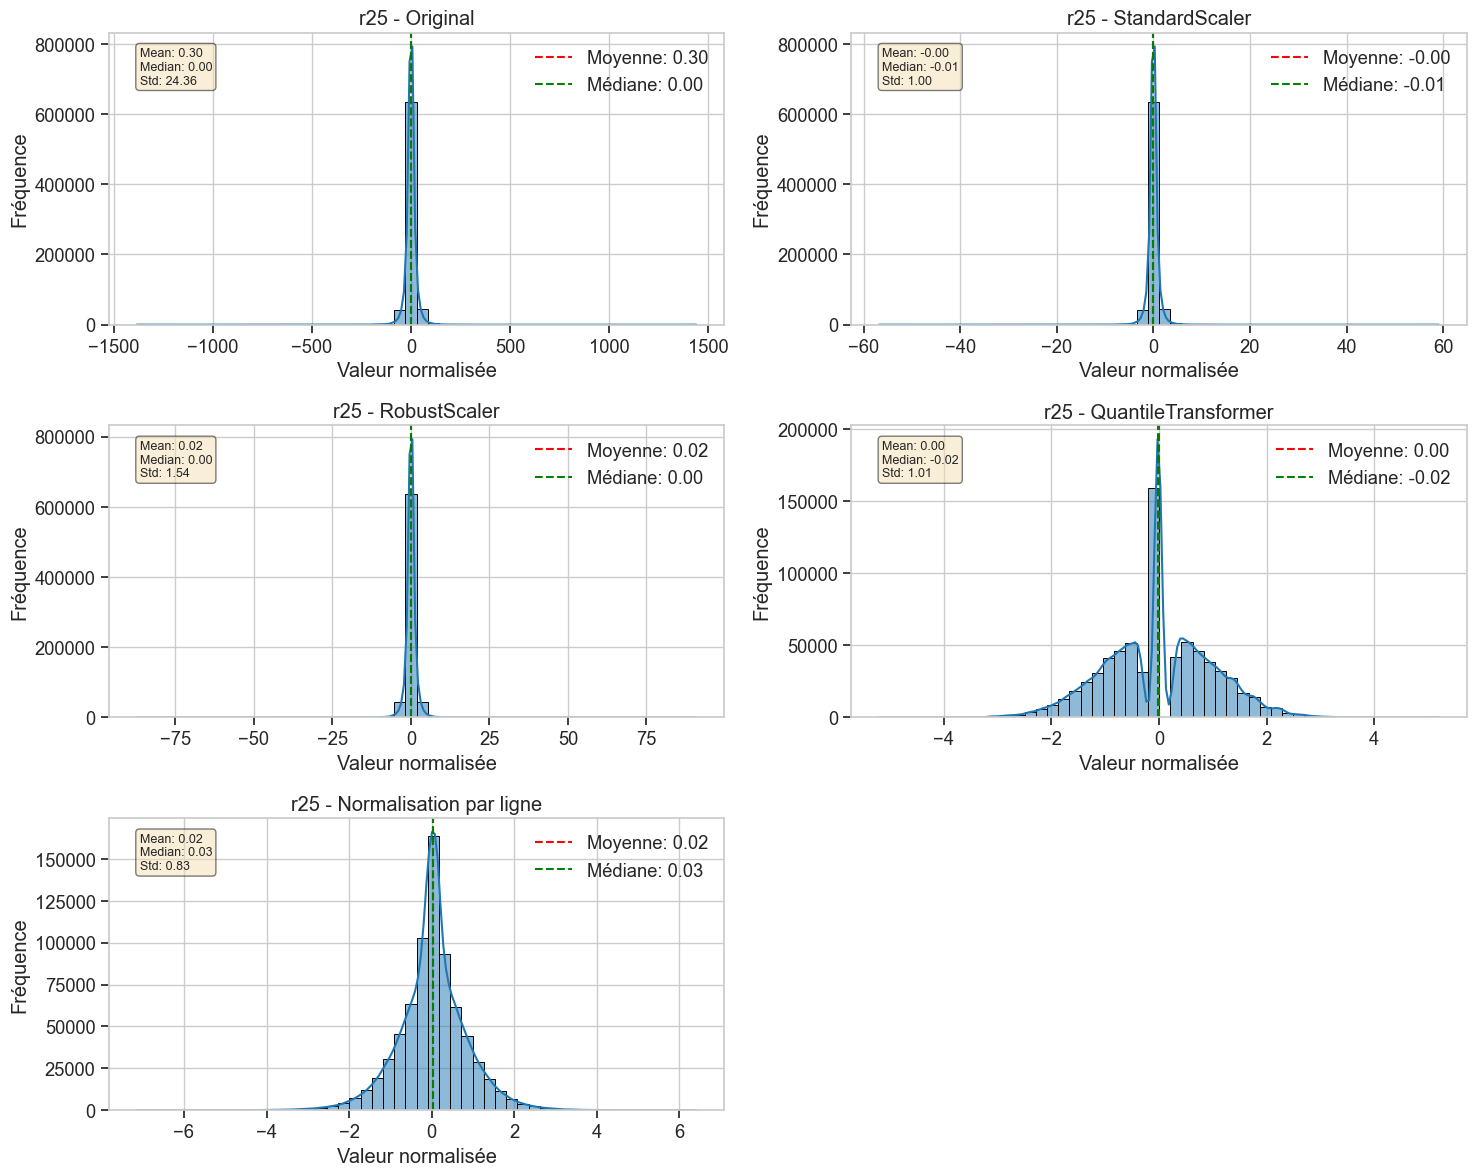

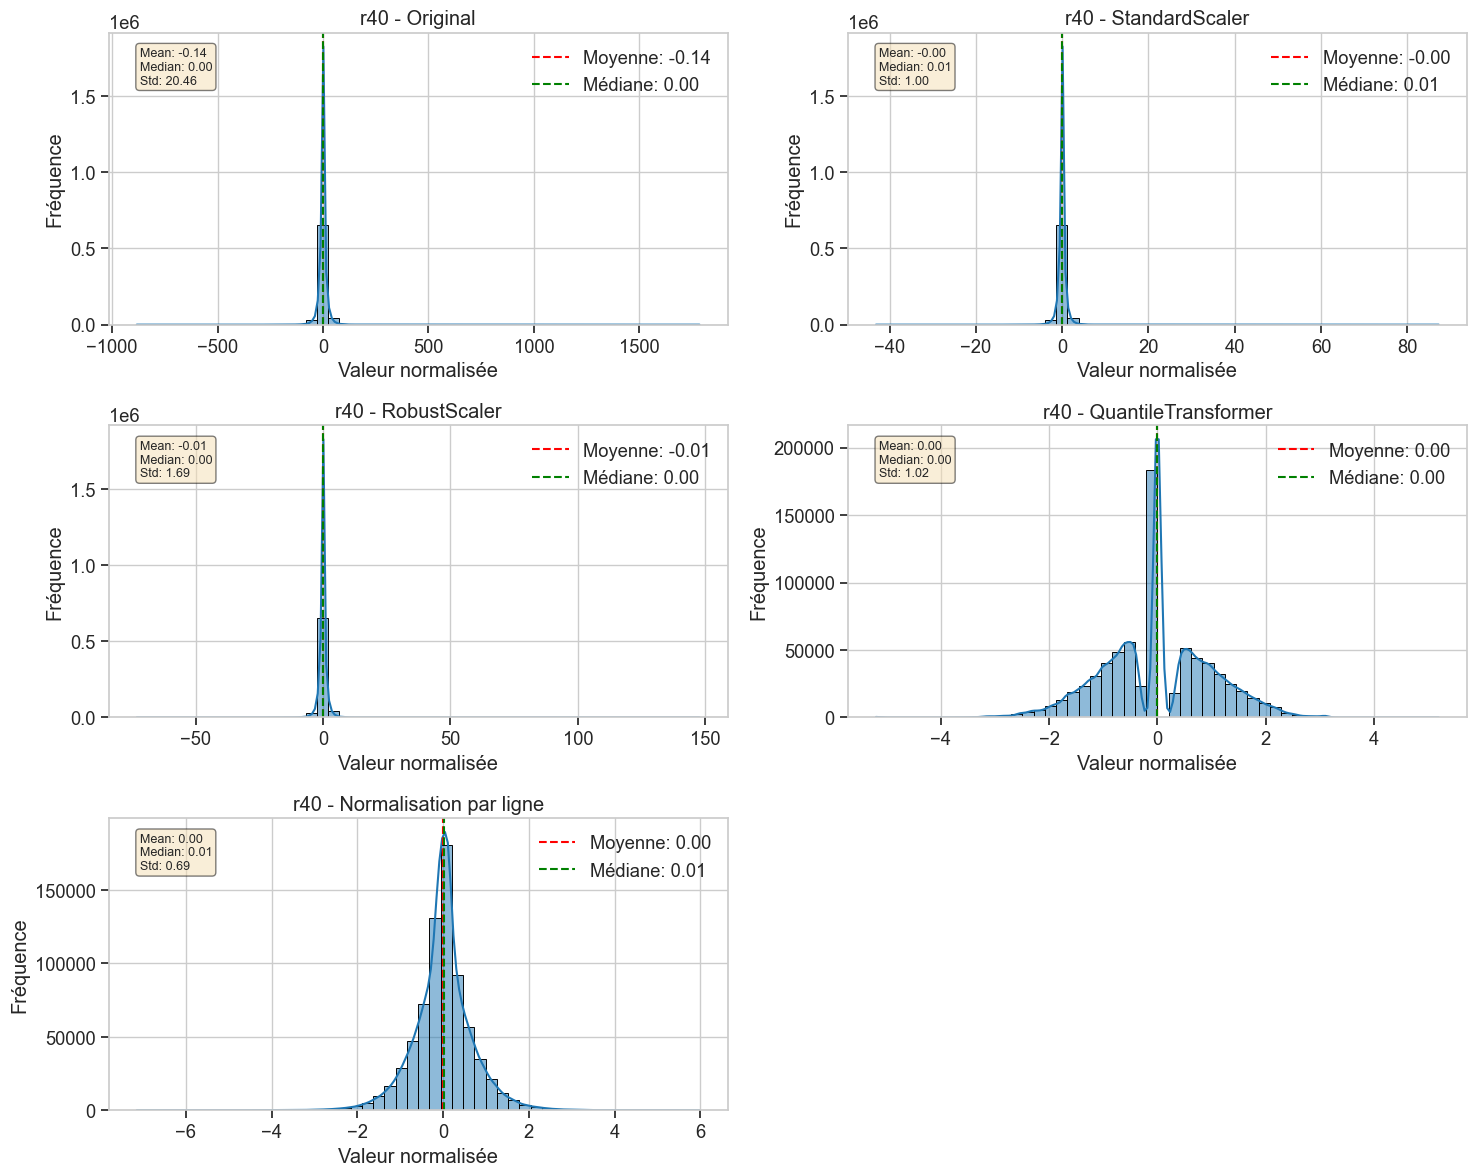

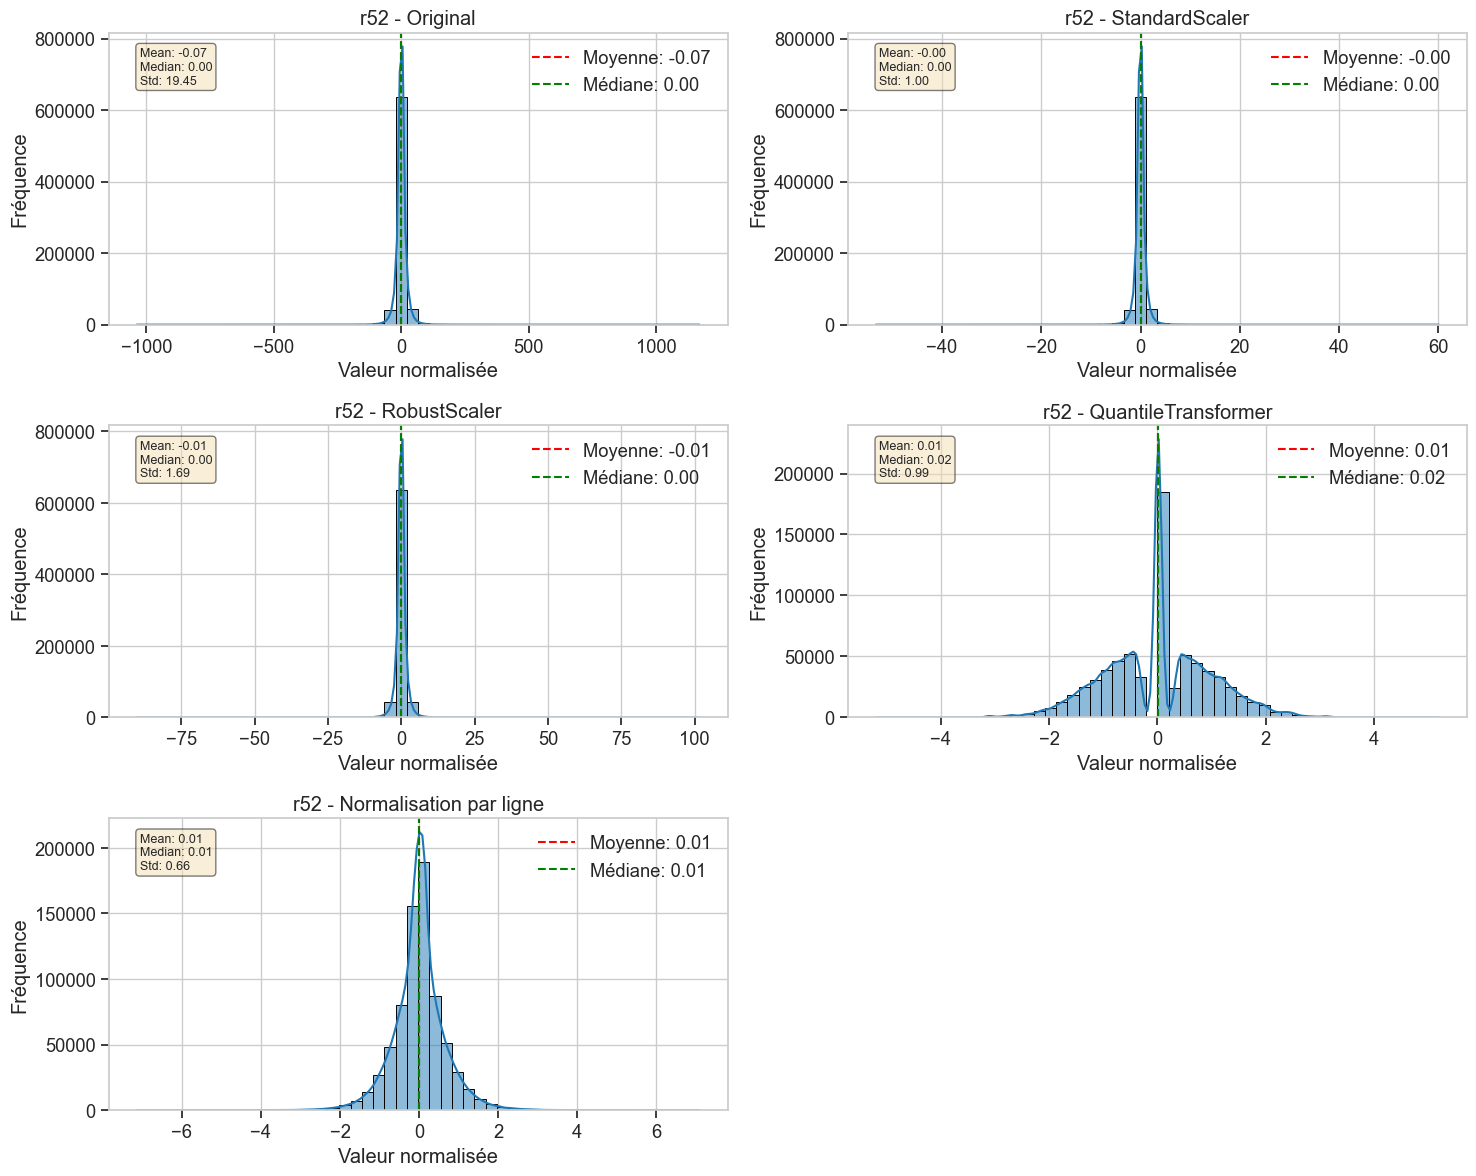


Statistiques après normalisation:


Kurtosis                                     \
Méthode Normalisation par ligne       Original QuantileTransformer   
Colonne                                                              
r0                     0.286115  314352.382928            0.013679   
r10                    1.406272     210.650947            0.051550   
r25                    2.413538     104.170176            0.105411   
r40                    2.922470     221.466285            0.161910   
r52                    3.511795     132.957589            0.031662   

                                                      Moyenne               \
Méthode   RobustScaler StandardScaler Normalisation par ligne     Original   
Colonne                                                                      
r0       314352.382928  314352.382928               -0.218097  2011.933860   
r10         210.650947     210.650947                0.023956     0.441309   
r25         104.170176     104.170176                0.021261     0.298970   
r40         221.466285     221.466285                0.002842    -0.138532   
r52         132.957589     132.957589                0.006341    -0.065975   

                                                         \
Méthode QuantileTransformer RobustScaler StandardScaler   
Colonne                                                   
r0                -0.012258    35.767713  -7.924261e-19   
r10                0.003693     0.020603  -5.226123e-18   
r25                0.003550     0.018874  -3.184289e-18   
r40                0.003460    -0.011458  -1.492240e-17   
r52                0.014569    -0.005737  -3.441949e-18   

                       Skewness                                               \
Méthode Normalisation par ligne    Original QuantileTransformer RobustScaler   
Colonne                                                                        
r0                    -0.250644  516.699019            0.002693   516.699019   
r10                    0.012088    1.762238            0.014312     1.762238   
r25                   -0.083359    0.372370            0.026336     0.372370   
r40                    0.028564    1.953211           -0.047241     1.953211   
r52                    0.069300    1.050953            0.032929     1.050953   

                                    Écart-type                 \
Méthode StandardScaler Normalisation par ligne       Original   
Colonne                                                         
r0          516.699019                2.629368  636970.524974   
r10           1.762238                1.044093      32.525730   
r25           0.372370                0.830841      24.358171   
r40           1.953211                0.685904      20.458597   
r52           1.050953                0.660190      19.449087   

                                                          
Méthode QuantileTransformer  RobustScaler StandardScaler  
Colonne                                                   
r0                 0.989147  11323.920444       1.000001  
r10                0.993222      1.518475       1.000001  
r25                1.006960      1.537763       1.000001  
r40                1.020160      1.692192       1.000001  
r52                0.989660      1.691225       1.000001

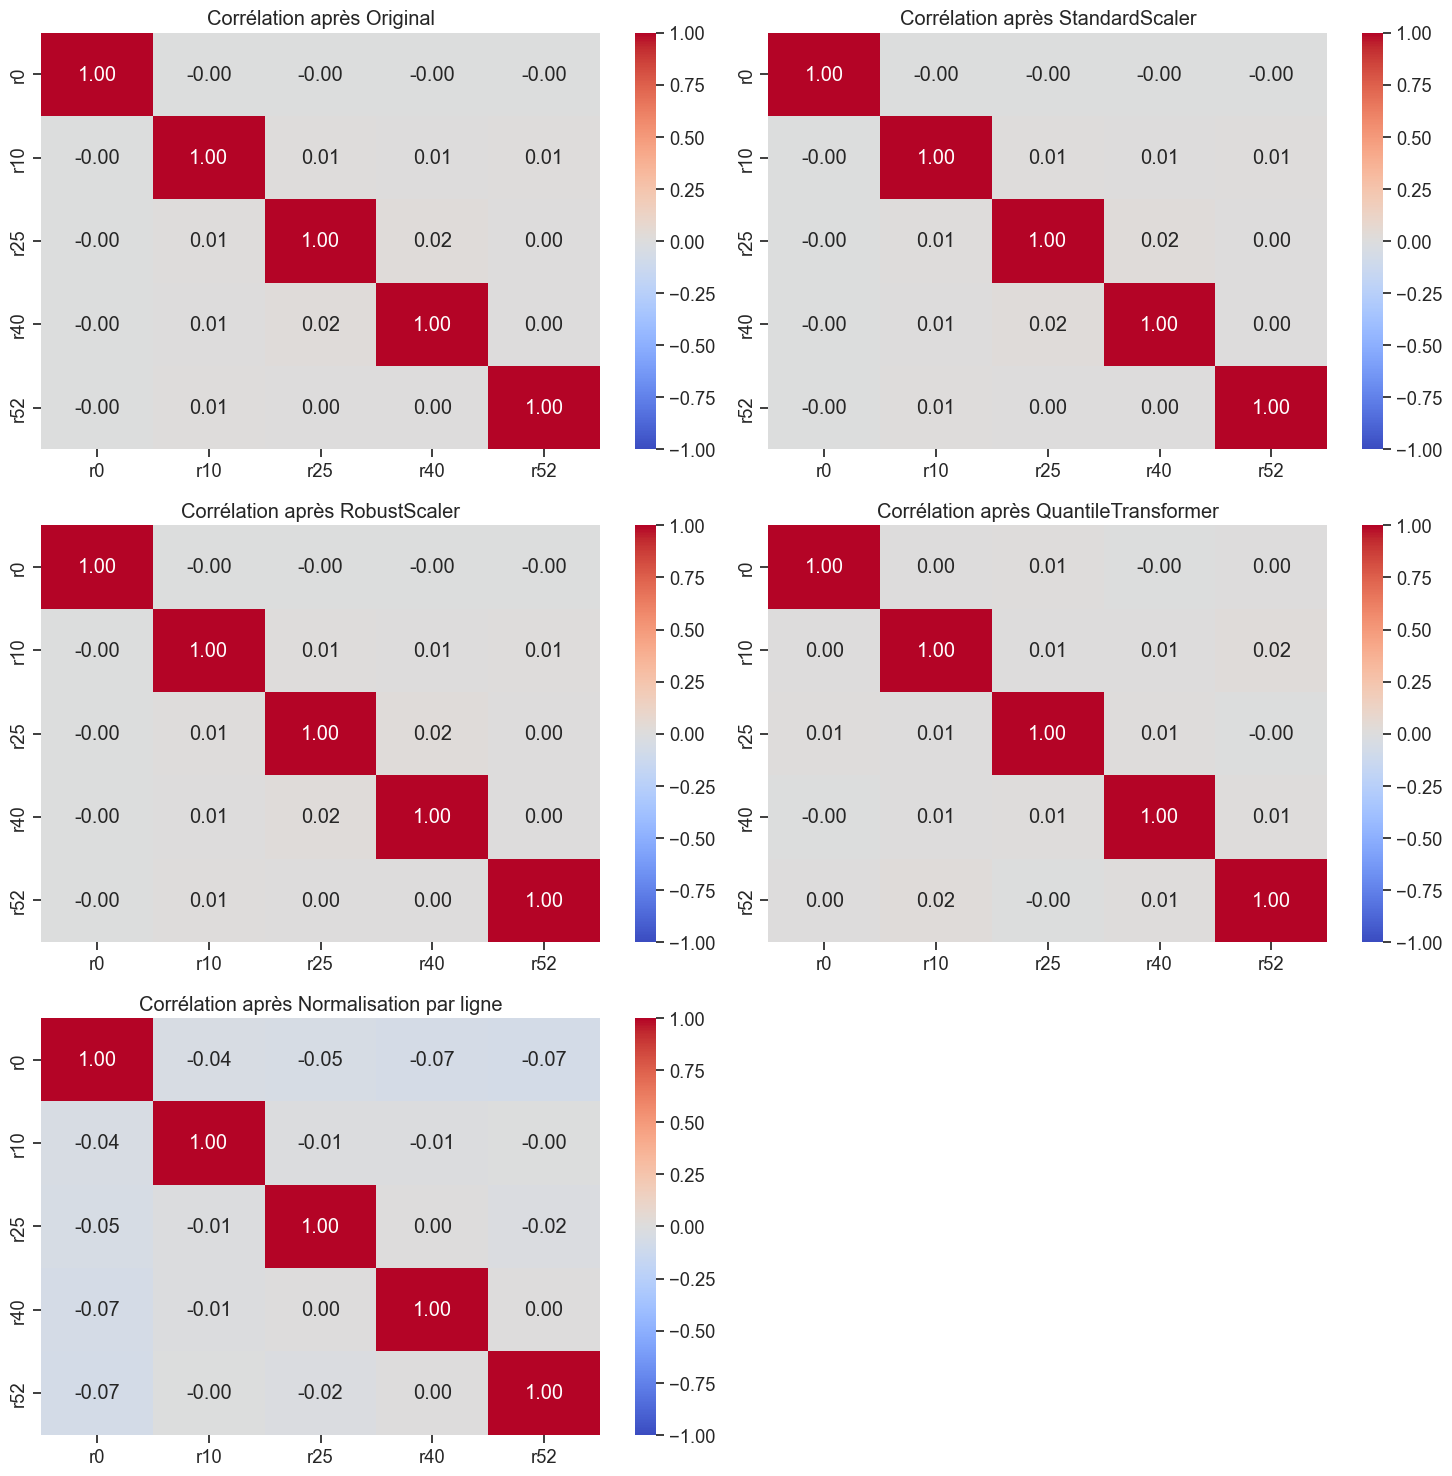

In [6]:
# Analyser l'impact des différentes méthodes de normalisation
normalization_results = analyze_normalization(imputed_datasets)


## 4. Modèles de référence (benchmarks)

Nous établissons des modèles de base pour servir de références aux futures améliorations.


In [7]:
print("\nDatasets disponibles:")
for key, info in DATASETS.items():
    print(f"- {key}: {info['description']}")

print("\nModèles disponibles:")
models = get_models()
for key, info in models.items():
    if 'description' in info:
        print(f"- {key}: {info['description']}")
    else:
        print(f"- {key}")


Datasets disponibles:
- raw: Données brutes
- ffbf: Données forward filled puis backward
- bfff: Données backward filled puis forward
- interp: Données interpolation linéaire puis bffff
- mice: Données MICE imputer puis bfff
- knn: Données knn imputer puis bfff

Modèles disponibles:
- xgboost_baseline: XGBoost de base
- xgboost_tuned: XGBoost avec paramètres 
- rf_baseline: Baseline Random Forest model
- logistic: Multinomial Logistic Regression



### 4.1 Configuration des expériences



### 4.2 XGBoost baseline

Le gradient boosting est souvent efficace pour les données tabulaires et gère bien les valeurs manquantes.



--- Baseline XGBoost sur données brutes ---

Résultats détaillés de l'expérience baseline:
Dataset: raw (Données brutes)
Model: xgboost_baseline (XGBoost de base)
Features Added: False
Feature Sets: None
Accuracy: 0.3268
Weighted F1-Score: 0.3263
Class-wise Performance:
  Class -1: Precision = 0.3008, Recall = 0.4032
  Class  0: Precision = 0.4113, Recall = 0.2710
  Class  1: Precision = 0.2889, Recall = 0.3266
Timing Information:
  Data Loading: 6.88 seconds
  Training: 15.56 seconds
  Prediction: 0.96 seconds
  Total Time: 23.40 seconds


c:\Users\julie\Documents\Python\Machine Learning - Projet FInal\utils\experiment_runner.py:170: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([results_tracker, pd.DataFrame([result])], ignore_index=True)


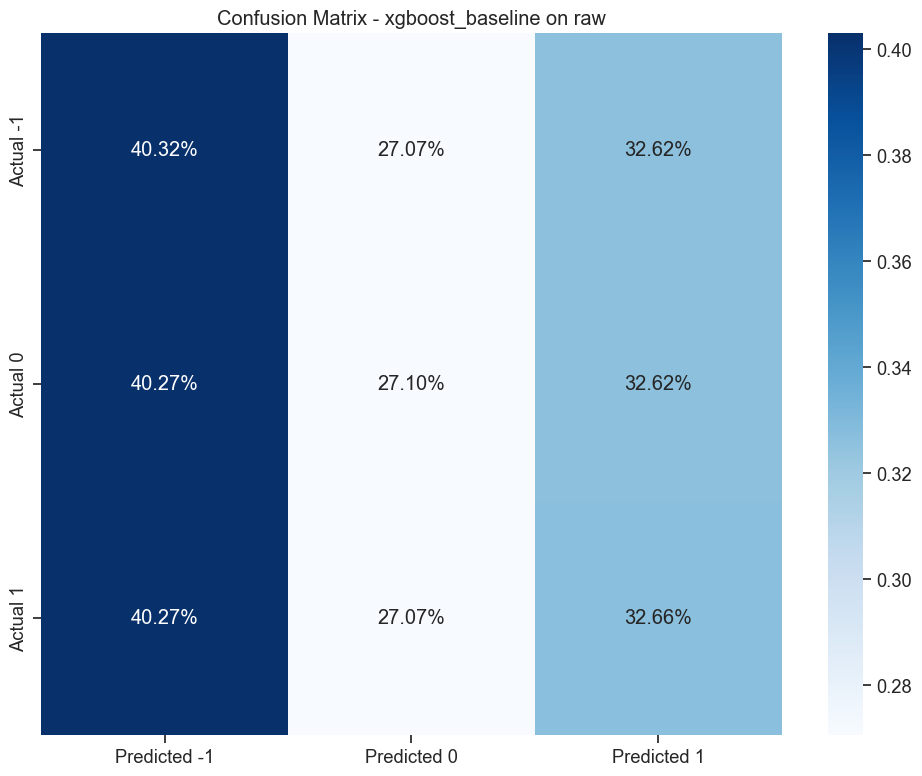

In [8]:
print("\n--- Baseline XGBoost sur données brutes ---")
baseline_result = run_experiment(dataset_key="raw", model_key="xgboost_baseline", add_feat=False)
results_tracker = add_result(results_tracker, baseline_result)
print("\nRésultats détaillés de l'expérience baseline:")
display_experiment_result(baseline_result)

In [9]:
print("\n--- Comparaison des stratégies d'imputation avec XGBoost ---")

imputation_strategies = ["raw", "ffbf", "bfff", "interp","knn","mice"]
imputation_results = []

for strategy in imputation_strategies:
    print(f"\nTesting {strategy} imputation...")
    try:
        # Sans feature engineering
        result_without_features = run_experiment(dataset_key=strategy, model_key="xgboost_baseline", add_feat=False)
        results_tracker = add_result(results_tracker, result_without_features)
        imputation_results.append(result_without_features)
        print(f"Accuracy without feature engineering: {result_without_features['accuracy']:.4f}")
        
        # Avec feature engineering
        result_with_features = run_experiment(dataset_key=strategy, model_key="xgboost_baseline", add_feat=True)
        results_tracker = add_result(results_tracker, result_with_features)
        imputation_results.append(result_with_features)
        print(f"Accuracy with feature engineering: {result_with_features['accuracy']:.4f}")
        
        # Amélioration due au feature engineering
        improvement = result_with_features['accuracy'] - result_without_features['accuracy']
        print(f"Improvement from feature engineering: {improvement:.4f} ({improvement*100:.2f}%)")
    except Exception as e:
        print(f"Error processing {strategy} dataset: {e}")


--- Comparaison des stratégies d'imputation avec XGBoost ---

Testing raw imputation...
Accuracy without feature engineering: 0.3268
Accuracy with feature engineering: 0.3254
Improvement from feature engineering: -0.0014 (-0.14%)

Testing ffbf imputation...
Accuracy without feature engineering: 0.3267
Accuracy with feature engineering: 0.3256
Improvement from feature engineering: -0.0010 (-0.10%)

Testing bfff imputation...
Accuracy without feature engineering: 0.3271
Accuracy with feature engineering: 0.3257
Improvement from feature engineering: -0.0014 (-0.14%)

Testing interp imputation...
Accuracy without feature engineering: 0.3267
Accuracy with feature engineering: 0.3253
Improvement from feature engineering: -0.0014 (-0.14%)

Testing knn imputation...
Error processing knn dataset: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3], got [ 0.  1.  2. nan]

Testing mice imputation...
Accuracy without feature engineering: 0.3256
Accuracy with feature engineeri

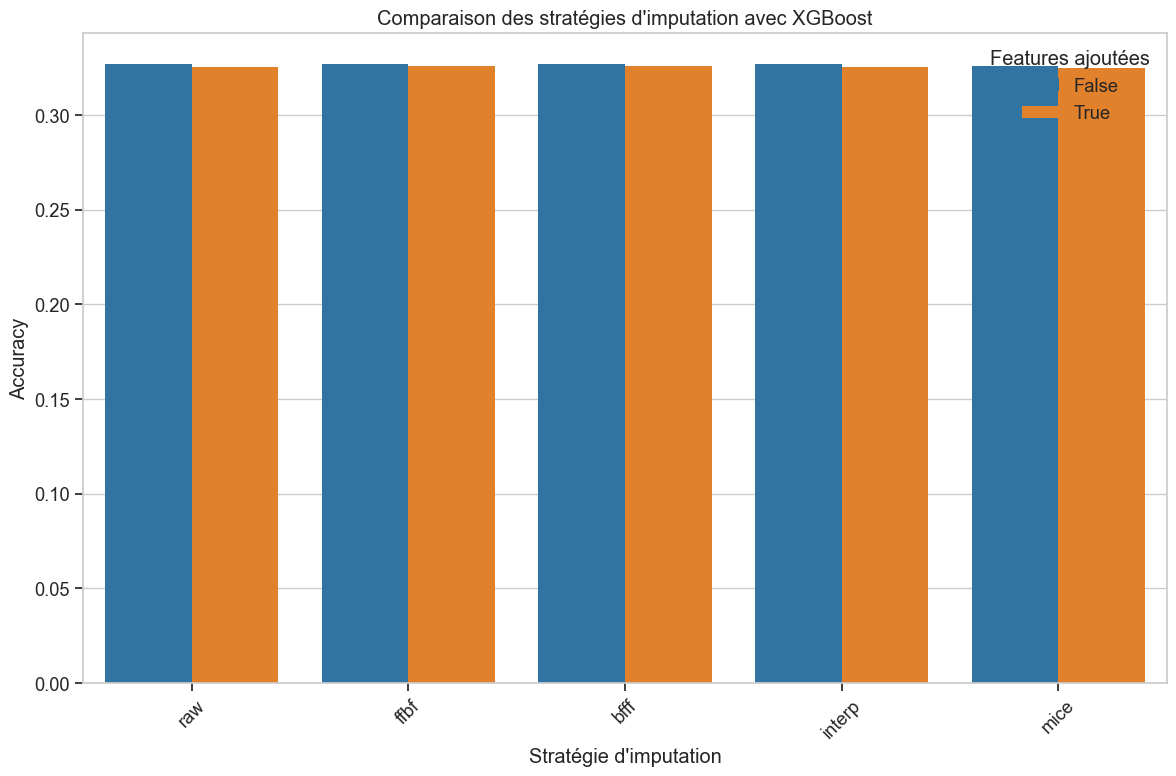

In [10]:
plt.figure(figsize=(12, 8))
sns.barplot(x='dataset', y='accuracy', hue='features_added', 
            data=results_tracker[results_tracker['model'] == 'xgboost_baseline'])
plt.title('Comparaison des stratégies d\'imputation avec XGBoost')
plt.xlabel('Stratégie d\'imputation')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Features ajoutées')
plt.tight_layout()
plt.show()

### 4.3 Régression logistique

Un modèle linéaire simple pour établir une référence de base.


c:\Users\julie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic regression on raw: Accuracy = 0.3396


c:\Users\julie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic regression on ffbf: Accuracy = 0.3460


c:\Users\julie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic regression on bfff: Accuracy = 0.3446


c:\Users\julie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic regression on interp: Accuracy = 0.3449
Error with logistic regression on knn: Input y contains NaN.


c:\Users\julie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Logistic regression on mice: Accuracy = 0.3424


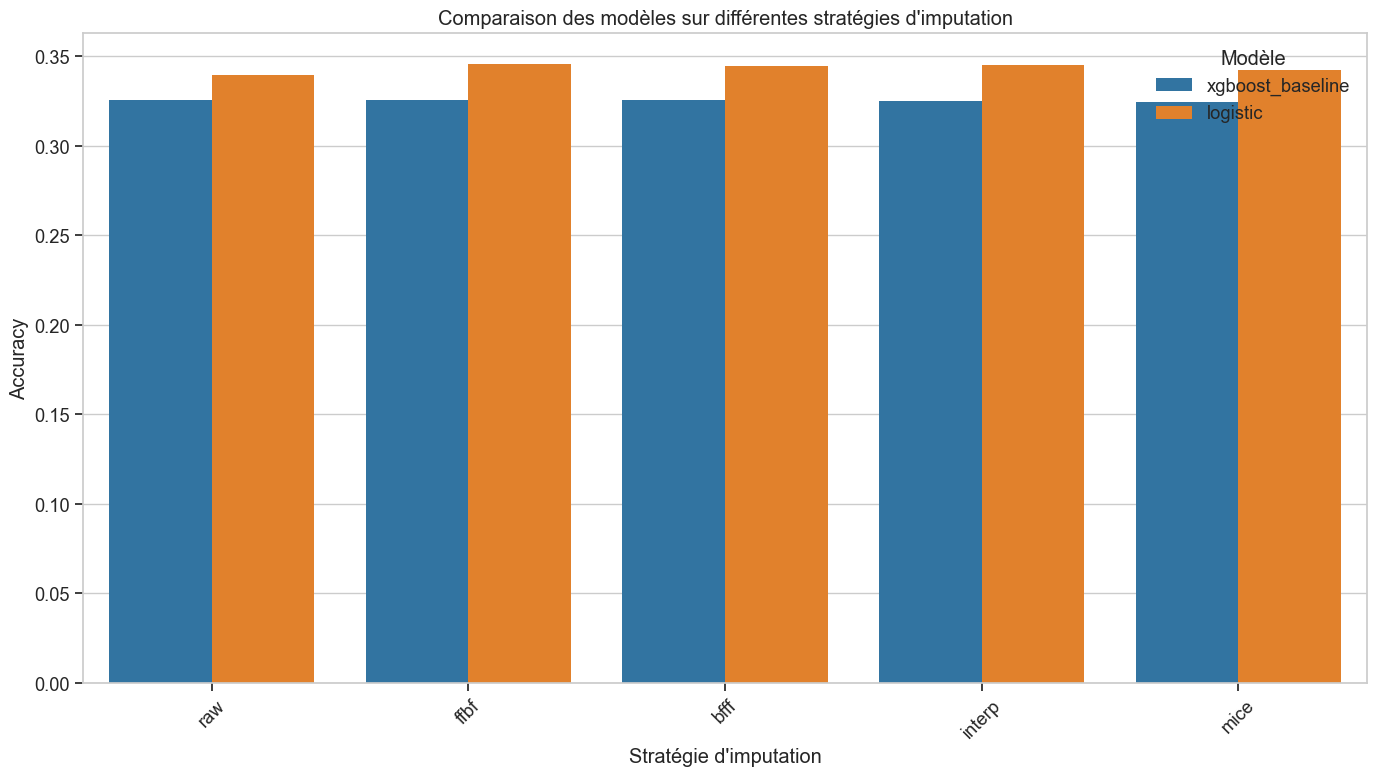

In [11]:
for strategy in imputation_strategies:
    try:
        result = run_experiment(dataset_key=strategy, model_key="logistic", add_feat=True)
        results_tracker = add_result(results_tracker, result)
        print(f"Logistic regression on {strategy}: Accuracy = {result['accuracy']:.4f}")
    except Exception as e:
        print(f"Error with logistic regression on {strategy}: {e}")
        
# Comparer les performances des modèles sur les différentes stratégies d'imputation
plt.figure(figsize=(14, 8))
sns.barplot(x='dataset', y='accuracy', hue='model', 
            data=results_tracker[results_tracker['features_added'] == True])
plt.title('Comparaison des modèles sur différentes stratégies d\'imputation')
plt.xlabel('Stratégie d\'imputation')
plt.ylabel('Accuracy')
plt.xticks(rotation=45)
plt.legend(title='Modèle')
plt.tight_layout()
plt.show()


### 4.4 Comparaison des benchmarks sur les différentes stratégies d'imputation




--- Analyse des résultats ---

Meilleur résultat global:
Dataset: ffbf (Données forward filled puis backward)
Model: logistic (Multinomial Logistic Regression)
Features Added: True
Accuracy: 0.3460
Weighted F1-Score: 0.3429

Comparaison des stratégies d'imputation (avec XGBoost):
bfff: Accuracy = 0.3257, F1 = 0.3245
ffbf: Accuracy = 0.3256, F1 = 0.3242
raw: Accuracy = 0.3254, F1 = 0.3244
interp: Accuracy = 0.3253, F1 = 0.3238
mice: Accuracy = 0.3247, F1 = 0.3229


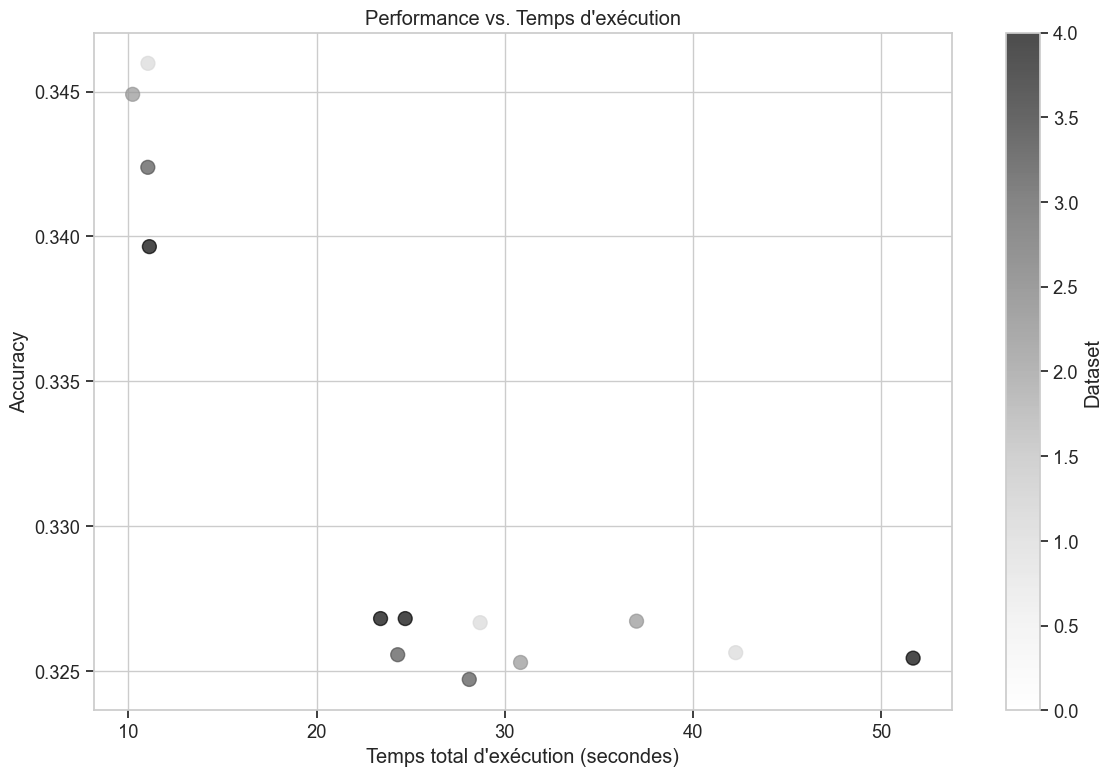

In [12]:
# 4.6 Analyse des résultats
print("\n--- Analyse des résultats ---")

# Trouver le meilleur résultat global
best_result = results_tracker.loc[results_tracker['accuracy'].idxmax()]
print(f"\nMeilleur résultat global:")
print(f"Dataset: {best_result['dataset']} ({best_result['dataset_description']})")
print(f"Model: {best_result['model']} ({best_result['model_description']})")
print(f"Features Added: {best_result['features_added']}")
print(f"Accuracy: {best_result['accuracy']:.4f}")
print(f"Weighted F1-Score: {best_result['f1_weighted']:.4f}")

# Comparaison des stratégies d'imputation
print("\nComparaison des stratégies d'imputation (avec XGBoost):")
imputation_comparison = results_tracker[
    (results_tracker['model'] == 'xgboost_baseline') & 
    (results_tracker['features_added'] == True)
].sort_values('accuracy', ascending=False)

for _, row in imputation_comparison.iterrows():
    print(f"{row['dataset']}: Accuracy = {row['accuracy']:.4f}, F1 = {row['f1_weighted']:.4f}")

# Performance vs Temps
plt.figure(figsize=(12, 8))
plt.scatter(results_tracker['total_time'], results_tracker['accuracy'], 
            c=results_tracker['dataset'].astype('category').cat.codes, 
            s=100, alpha=0.7)
plt.xlabel('Temps total d\'exécution (secondes)')
plt.ylabel('Accuracy')
plt.title('Performance vs. Temps d\'exécution')
plt.grid(True)
plt.colorbar(label='Dataset')
plt.tight_layout()
plt.show()

## 5. Analyse  des features

Après avoir établi des benchmarks, nous cherchons à améliorer les performances en analysant et en créant de nouvelles features.

### 5.1 Analyse en composantes principales (PCA)

La PCA nous aide à comprendre la structure des données et à réduire la dimensionnalité.



Analyse PCA sur le dataset ffbf...
Temps de chargement: 2.98 secondes
Temps d'exécution PCA: 0.02 secondes
Composantes nécessaires pour 70.0% de variance expliquée: 35
Composantes nécessaires pour 80.0% de variance expliquée: 41
Composantes nécessaires pour 90.0% de variance expliquée: 47
Composantes nécessaires pour 95.0% de variance expliquée: 50
Composantes nécessaires pour 99.0% de variance expliquée: 53


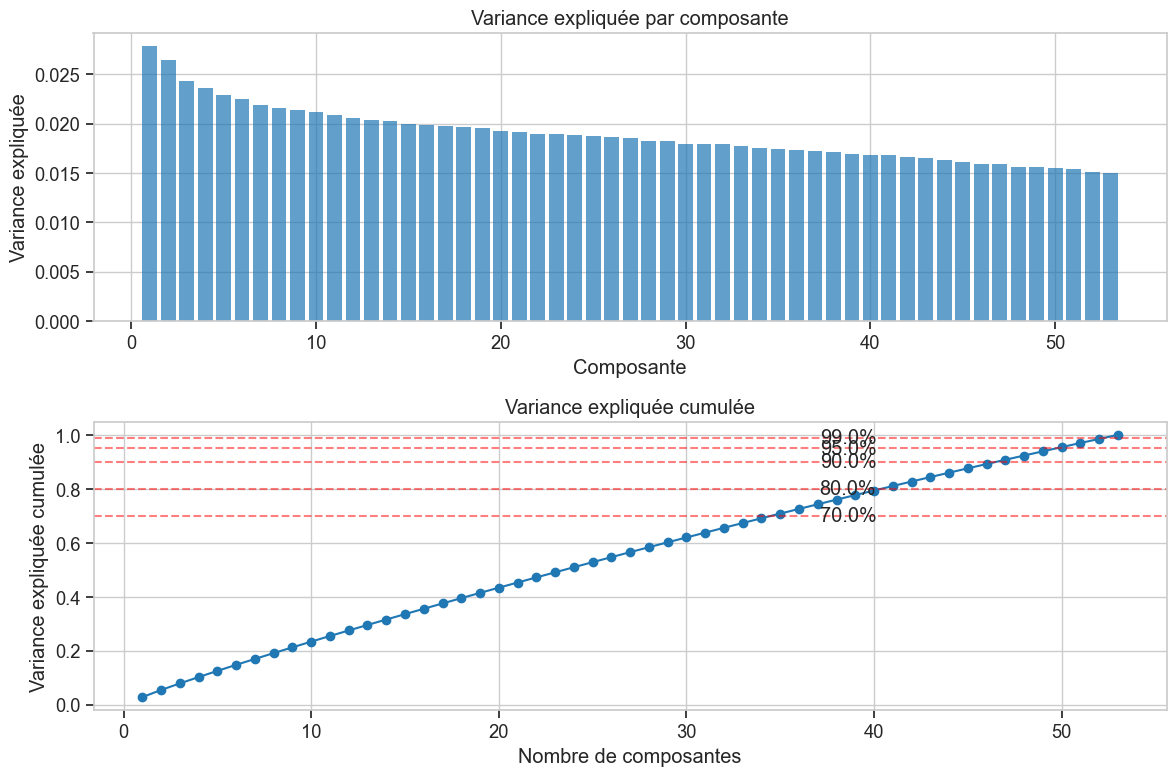

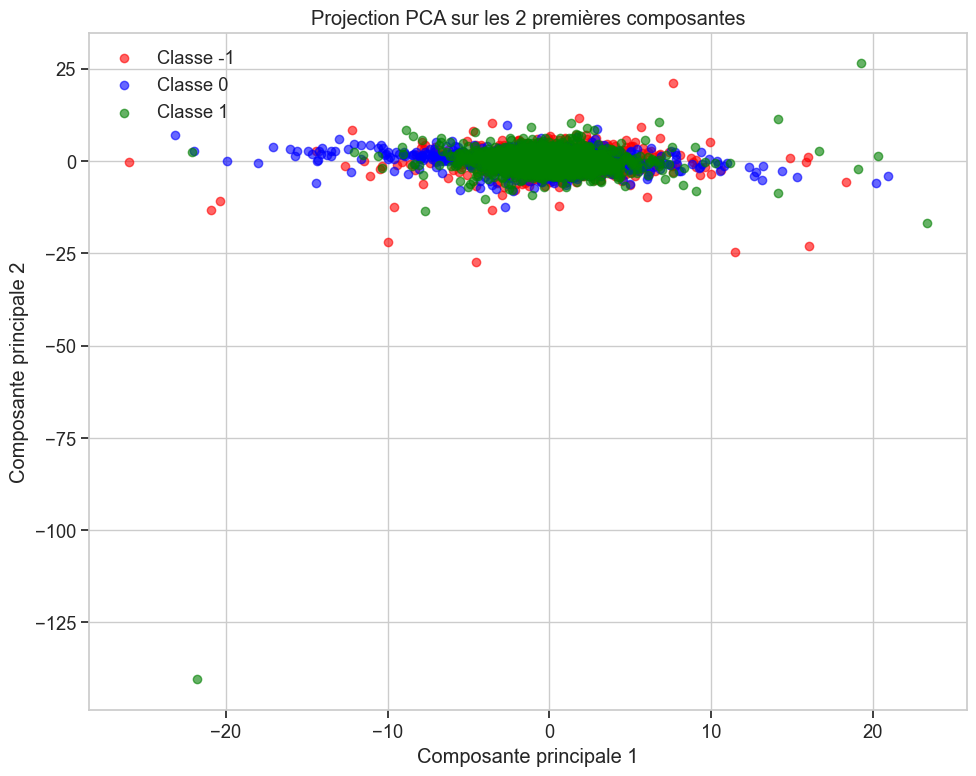

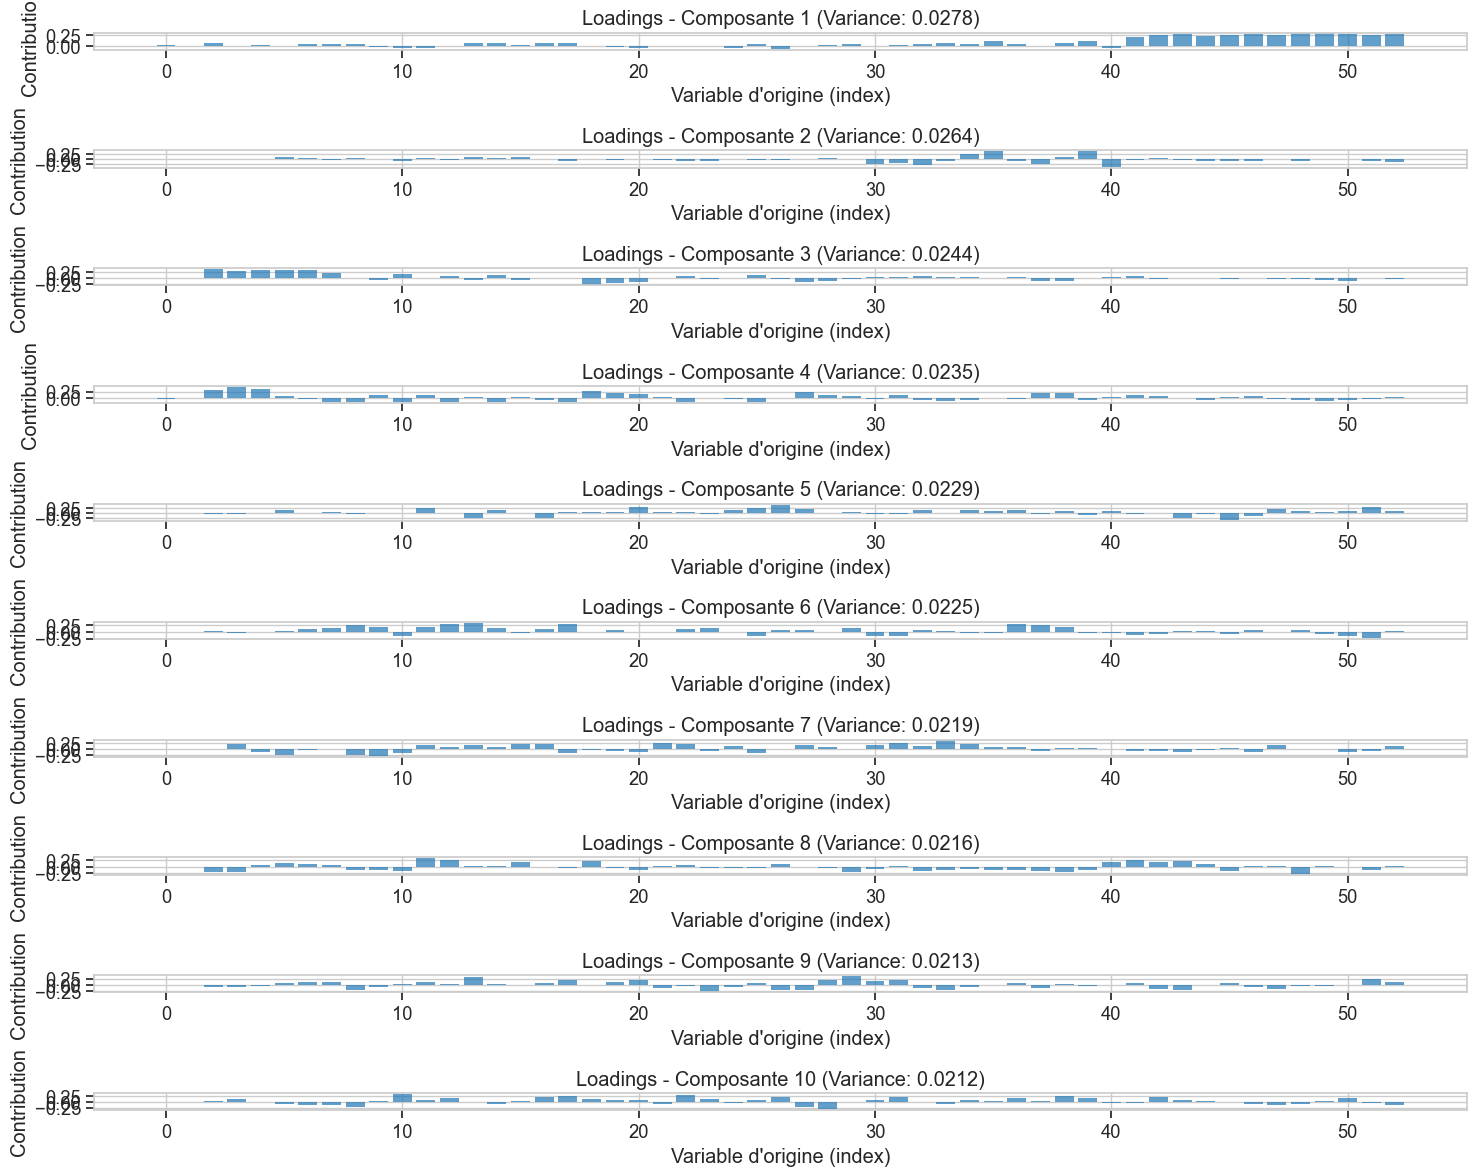


Variables les plus contributives par composante:

Composante 1:
  r49: 0.2980
  r48: 0.2940
  r50: 0.2930
  r46: 0.2922
  r52: 0.2892

Composante 2:
  r35: 0.4190
  r39: 0.4116
  r40: -0.3758
  r32: -0.2947
  r34: 0.2802

Composante 3:
  r2: 0.3749
  r5: 0.3445
  r6: 0.3411
  r4: 0.3232
  r3: 0.3084

Composante 4:
  r3: 0.4282
  r4: 0.3470
  r2: 0.3029
  r18: 0.2901
  r27: 0.2229

Composante 5:
  r26: 0.3924
  r45: -0.3326
  r20: 0.2665
  r51: 0.2614
  r25: 0.2521

Composante 6:
  r13: 0.3498
  r36: 0.3088
  r12: 0.3084
  r17: 0.3070
  r8: 0.2474

Composante 7:
  r33: 0.3470
  r9: -0.2778
  r8: -0.2530
  r31: 0.2477
  r21: 0.2416

Composante 8:
  r11: 0.3386
  r41: 0.2773
  r12: 0.2673
  r48: -0.2648
  r43: 0.2321

Composante 9:
  r29: 0.3574
  r13: 0.3039
  r23: -0.2751
  r51: 0.2254
  r28: 0.2106

Composante 10:
  r10: 0.3363
  r28: -0.3290
  r22: 0.2758
  r17: 0.2339
  r8: -0.2307


In [13]:
# Effectuer l'analyse PCA sur le dataset ayant donné les meilleurs résultats
# Selon les benchmarks, utiliser le dataset avec la meilleure performance
best_dataset = "ffbf"  # À remplacer par le dataset ayant donné les meilleurs résultats
pca_results = perform_pca_analysis(dataset_key=best_dataset, sample_size=50000)


### 5.2 Visualisation t-SNE



Analyse t-SNE sur le dataset ffbf...
Temps de chargement: 2.96 secondes


c:\Users\julie\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
c:\Users\julie\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] Le fichier spécifié est introuvable
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\julie\AppData\Local\Programs\Python\Python312\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "c:\Users\julie\AppData\Local\Programs\Python\Python312\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:


Temps d'exécution t-SNE: 20.32 secondes


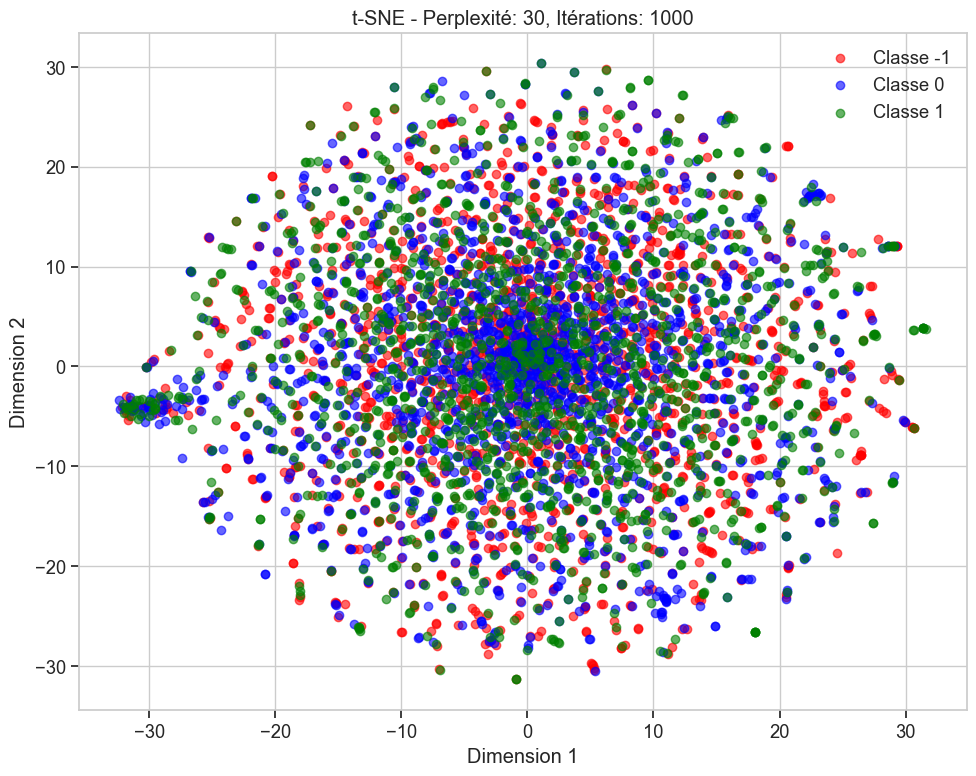

In [14]:
# Effectuer l'analyse t-SNE sur le dataset ayant donné les meilleurs résultats
tsne_results = perform_tsne_analysis(dataset_key=best_dataset, sample_size=5000)


### 5.3 Analyse des corrélations

Identifions les features redondantes pour simplifier nos modèles.



Analyse des corrélations sur le dataset ffbf...
Temps de chargement: 3.08 secondes
Temps de calcul des corrélations: 0.23 secondes


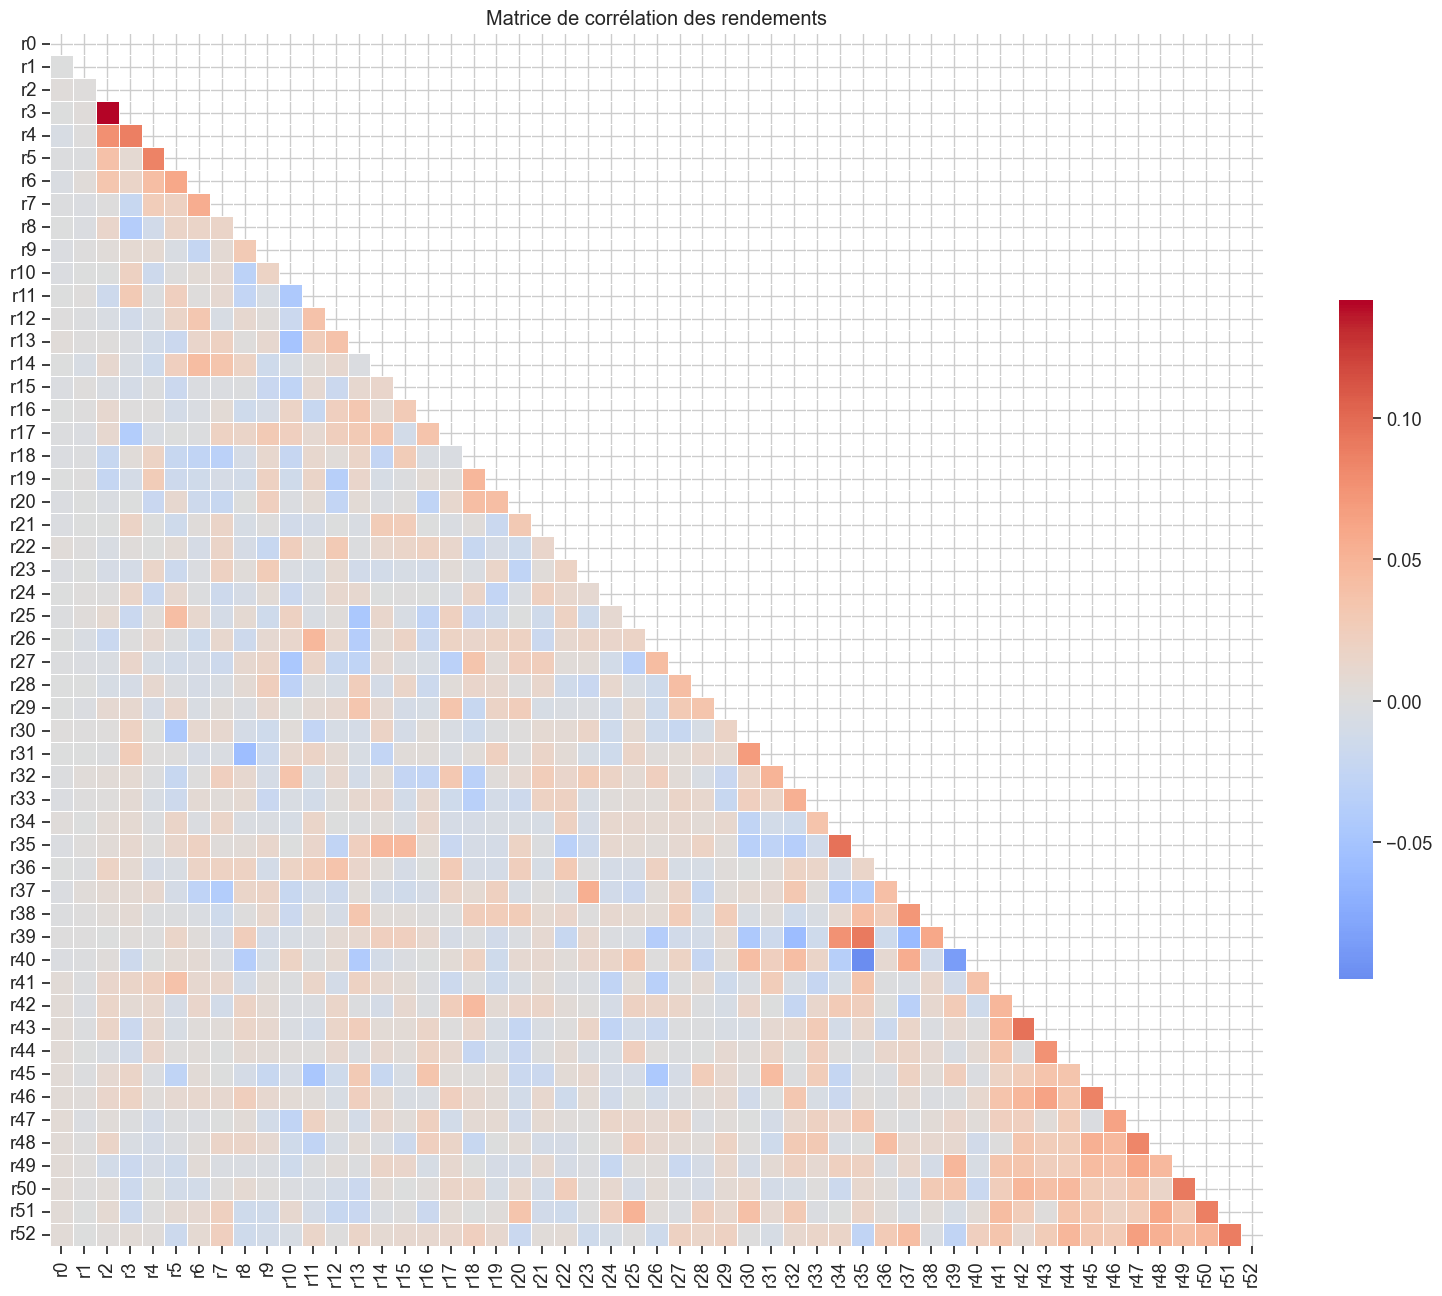


Paires de variables avec corrélation > 0.8:


Empty DataFrame
Columns: [Variable 1, Variable 2, Corrélation]
Index: []

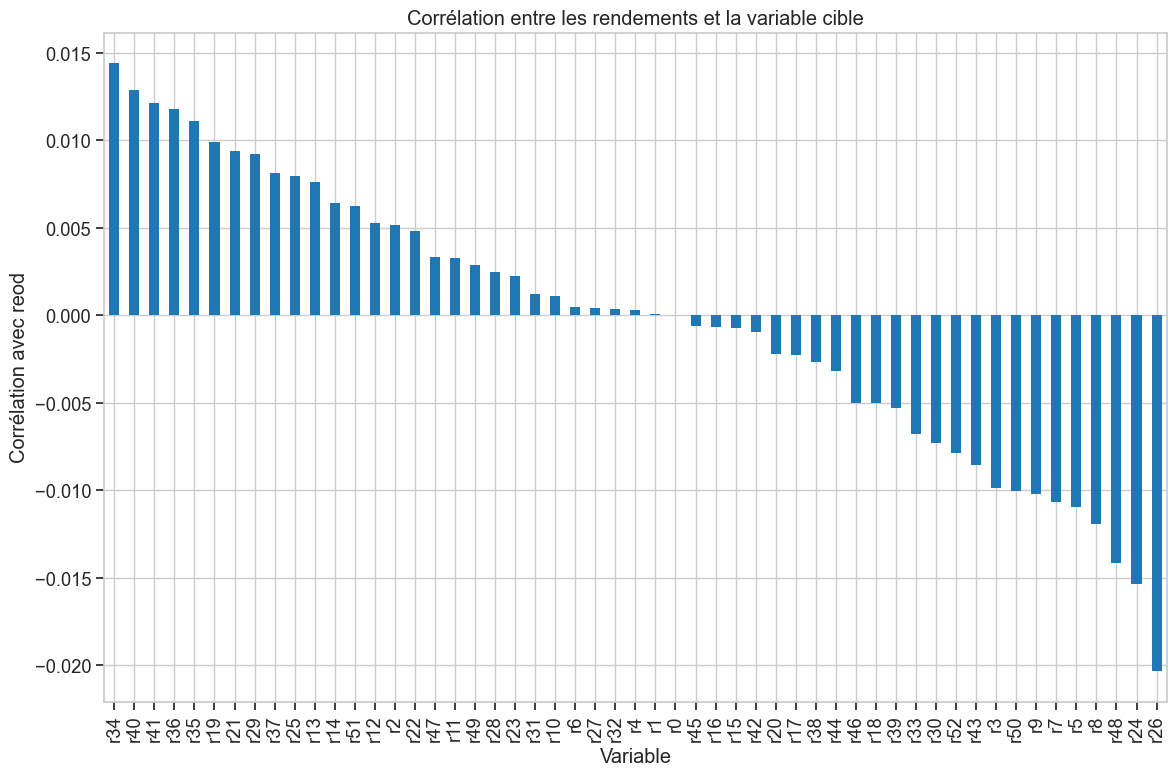


Variables les plus corrélées positivement avec la cible:


r34    0.014434
r40    0.012859
r41    0.012172
r36    0.011817
r35    0.011088
r19    0.009888
r21    0.009405
r29    0.009251
r37    0.008168
r25    0.007993
dtype: float64


Variables les plus corrélées négativement avec la cible:


r43   -0.008573
r3    -0.009882
r50   -0.010054
r9    -0.010193
r7    -0.010675
r5    -0.010986
r8    -0.011935
r48   -0.014144
r24   -0.015367
r26   -0.020340
dtype: float64

In [15]:
# Effectuer l'analyse des corrélations
correlation_results = analyze_correlations(dataset_key=best_dataset)


### 5.4 Evaluation de différents ensembles de features. 
Créons des features dérivées pour capturer des motifs complexes dans les rendements.



Évaluation des ensembles de features sur ffbf avec xgboost_baseline...

Test avec feature_set = None
Accuracy avec Toutes: 0.3256
Accuracy sans features: 0.3267

Test avec feature_set = ['basic_stats']
Accuracy avec basic_stats: 0.3264

Test avec feature_set = ['technical']
Accuracy avec technical: 0.3262

Test avec feature_set = ['basic_stats', 'technical']
Accuracy avec basic_stats, technical: 0.3256

Résumé des performances avec différents ensembles de features:


Feature Set  Accuracy  F1 Score  Train Time (s)  Total Time (s)
1       Aucune (baseline)  0.326668  0.326064       16.263625       23.714731
2             basic_stats  0.326382  0.325750       17.855859       25.386625
3               technical  0.326164  0.324790       18.341123       26.086302
0                  Toutes  0.325633  0.324202       20.554568       28.282447
4  basic_stats, technical  0.325633  0.324202       20.222680       28.146493

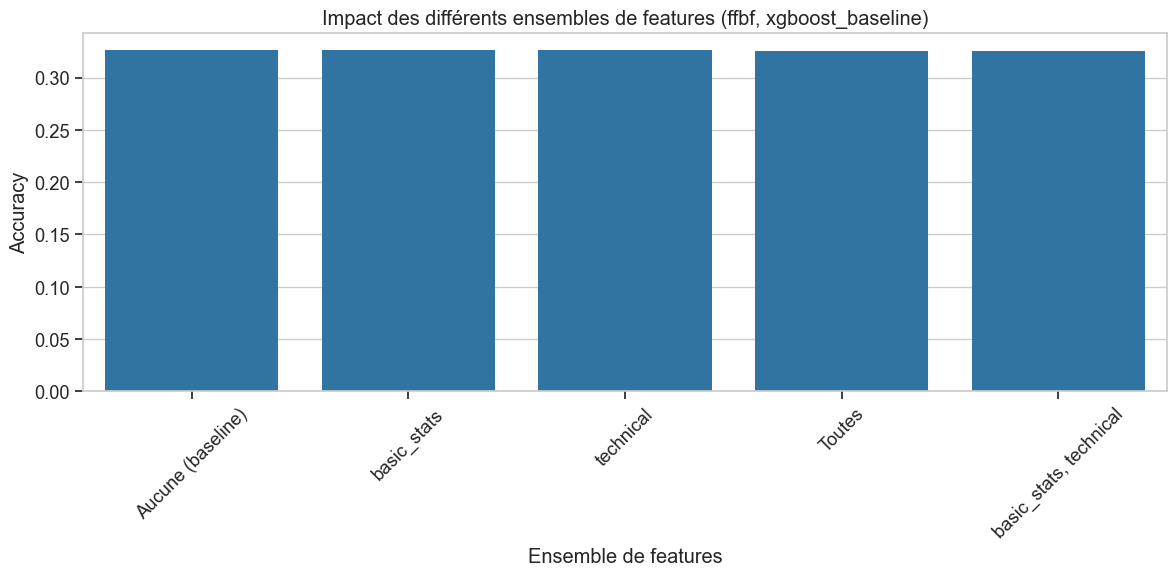

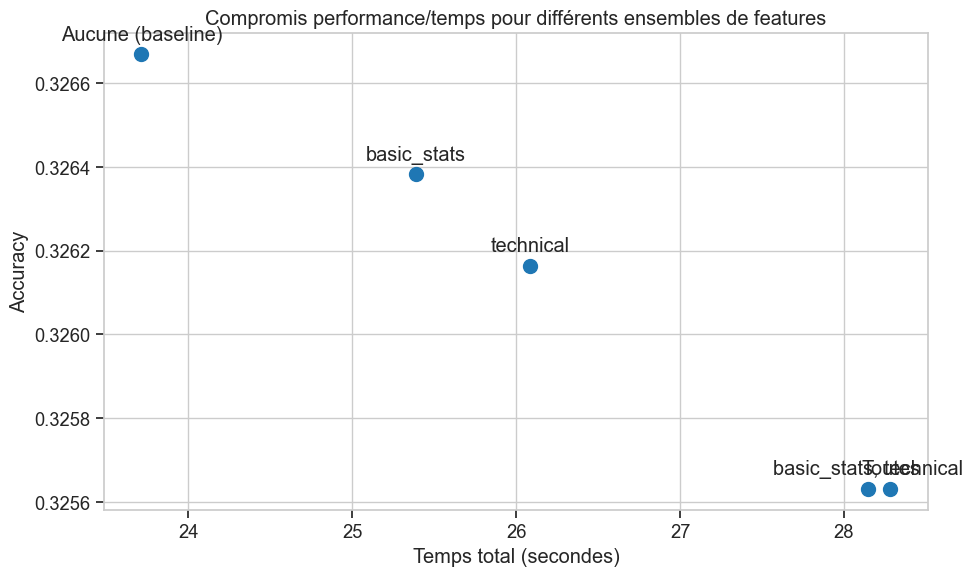

In [16]:

# Évaluer les différents ensembles de features
feature_evaluation = evaluate_feature_sets(dataset_key=best_dataset)

### 5.5 Analyse des features les plus pertinentes

In [17]:
# Analyser l'importance des features sur le meilleur dataset
feature_importance, model = analyze_feature_importance(dataset_key=best_dataset, add_features=True, 
                                                     feature_sets=["basic_stats", "technical"])


Erreur lors de l'analyse de l'importance des features: 'bool' object is not callable


### 5.6  Analyse des meilleures features

In [18]:
# Sélectionner les meilleures features
best_features = select_best_features(feature_importance, threshold=0.01)

Aucune information d'importance disponible.


### Résumé 

In [19]:
summarize_feature_analysis(pca_results, correlation_results, feature_importance, best_features)

Principales découvertes de l'analyse des features:


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

## 6. Modèles optimisés

Avec nos nouvelles insights et features, améliorons nos modèles.

### 6.1 Sélection des features optimales



```python
# Code pour la sélection de features
```


### 6.2 Optimisation des hyperparamètres



```python
# Code pour l'optimisation
```



### 6.3 Comparaison avec les benchmarks

```python
# Code pour la comparaison
```


## 7. Méthodes avancées

Explorons des approches plus sophistiquées pour améliorer encore les performances.

### 7.1 Clustering non supervisé



### 7.2 Modèles ensemblistes avancés


```python
# Code pour les modèles ensemblistes
```



## 8. Interprétabilité des modèles

Analysons comment nos modèles prennent leurs décisions.

### 8.1 SHAP values



```python
# Code pour SHAP
```


### 8.2 Analyse des erreurs





## 9. Conclusion

### 9.1 Synthèse des résultats

### 9.2 Recommandations

### 9.3 Perspectives futures